In [1]:
# !pip install --user faker

In [2]:
from PIL import Image, ImageOps, ImageFilter, ImageChops
from IPython import display
import random

IMG = Image.open('./judgement2.jpg')

def random_image(img=IMG, size=(200, 100)):
    width, height = size
    sqrt2 = 2 ** .5
    regionsize = int(min(
        max(width, height) * sqrt2,
        min(img.size),
    ))
    inscribed = int(regionsize / sqrt2)
    x = random.randint(0, img.width - regionsize)
    y = random.randint(0, img.height - regionsize)
    subsection = img.crop([x, y, x+regionsize, y+regionsize])
    angle = random.randint(0, 360)
    rotated = subsection.rotate(angle)
    cropbox = [
    ]
    ratio = width / height
    if ratio > 1:
        cw, ch = inscribed, inscribed / ratio 
    else:
        cw, ch = inscribed * ratio, inscribed
    cropbox = (
        (regionsize-cw)/2, 
        (regionsize-ch)/2,
        (regionsize+cw)/2,
        (regionsize+ch)/2,
    )
    cropped = rotated.crop(cropbox)
    blur = ImageFilter.GaussianBlur(1)
    result = cropped.resize((width, height))
    enhanced = result.filter(blur)
    enhanced = random_bands(enhanced)
    blended = ImageChops.blend(result, enhanced, 0.5)
    blended = ImageChops.blend(blended, ImageOps.equalize(blended), 0.5)
    blended = blended.filter(blur)
    #blended =  ImageOps.equalize(blended)
    return blended 

def random_bands(img):
    r,g,b = img.split()
    bands = [r,g,b]
    dice = [True] * 2 + [False] * 3 
    random.shuffle(dice)
    if dice.pop():
        random.shuffle(bands)
    negbands = (ImageChops.invert(b) for b in bands)
    bands = [n if d else b for (b, n, d) in zip(bands, negbands, dice)]
    newimg = Image.merge('RGB', bands)
    newimg = ImageOps.equalize(newimg)
    return newimg



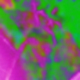
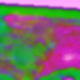
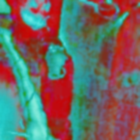
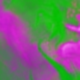
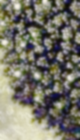
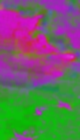
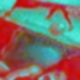
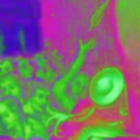
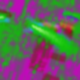
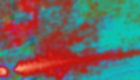
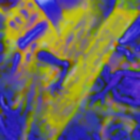
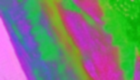
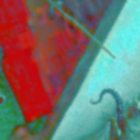
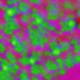
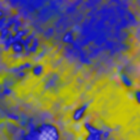
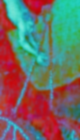
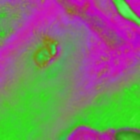
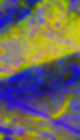
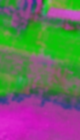
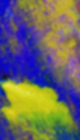
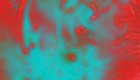
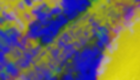
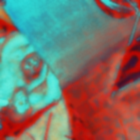
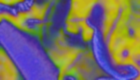
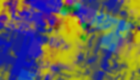
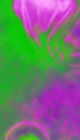
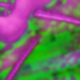
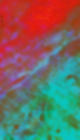
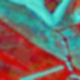
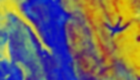
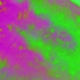
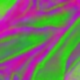
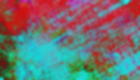
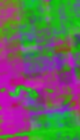
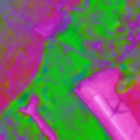
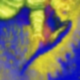
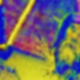
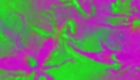
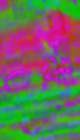
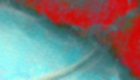
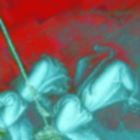
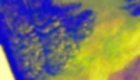
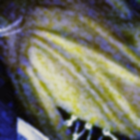
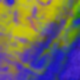
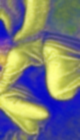
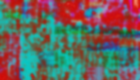
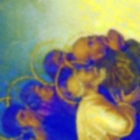
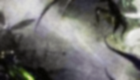
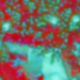
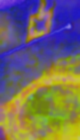

In [3]:
from io import BytesIO
import base64

def data_url(image):
    b = BytesIO()
    image.convert('RGB').save(b, 'PNG')
    raw = b.getvalue()
    data = base64.encodebytes(raw).decode('ascii').replace('\n', '')
    return 'data:image/png/;base64,{}'.format(data)

def image_to_html_img(image, style={}, **attrs):
    attrs['style'] = '{}'.format(';'.join('{}: {}'.format(*item) for item in style.items()))
    attrs['src'] = data_url(image)
    html = '<img {} />'.format(' '.join('{}="{}"'.format(*item) for item in attrs.items()))
    return html

def make_images(n=1, in_range=range(200,500,100)):
    choice = lambda: random.choice(in_range)
    images = (random_image(size=(choice(), choice())) for _ in range(n))
    style = {'display': 'inline-block', 'margin': '2px'}
    html = ''.join(image_to_html_img(img, style, title=img.size) for img in images)
    return display.HTML(html)

make_images(50, range(80, 200, 60))

In [4]:
from django.core.files import File
from faker import Factory
FAKE = Factory.create('no')

def fake_imagefile(size=(1200, 600), class_=ImageFile, fake=FAKE, **kwargs):
    image = random_image(size=size)
    blob = BytesIO()
    image.convert('RGB').save(blob, 'JPEG')
    filename = kwargs.pop('filename', fake.file_name(extension='jpg'))
    instance = class_(**kwargs)
    content = File(blob)
    instance.source_file.save(filename, content)
    return instance

def fake_contributor(fake=FAKE, **kwargs):
    name = fake.name()
    filename = '{}.jpg'.format(name).lower()
    byline_photo = fake_imagefile((400,400), ProfileImage, filename=filename)
    instance = Contributor(
        byline_photo = byline_photo,
        display_name = name,
        phone = fake.phone_number(),
        email = fake.email(),
        verified = True,
    )
    instance.save()
    return instance

In [5]:
def fake_story_image(story, byline):
    imagefile = fake_imagefile(contributor=byline)
    instance = StoryImage(
        parent_story = story,
        caption = 'foobar',
        imagefile = imagefile,
    )
    instance.save()
    return instance

In [6]:
def random_contributor():
    try:
        return Contributor.objects.order_by('?').first()
    except Contributor.DoesNotExist:
        fake_contributor()

def random_storytype():
    return StoryType.objects.order_by('?').first()

def fake_story_content(fake=FAKE):
    sections = "@tit:{title}", "@ing:{lede}", "@txt:{content}"
    title = fake.sentence(random.choice([1,2,3]))
    lede = ' '.join(fake.sentences(random.choice([1,2,3])))
    content = '\n'.join(fake.paragraphs(random.choice([4,5,10,20,30])))
    return '\n'.join(sections).format(title=title, lede=lede, content=content)


def fake_story():
    photo_by = random_contributor()
    text_by = random_contributor()
    markup = '{}\n@bl: text: {}\n@bl: photo:{}'.format(
        fake_story_content(), text_by, photo_by)
    
    print(markup)
    
    story = Story(
        story_type=random_storytype(),
        bodytext_markup=markup,
        publication_status = Story.STATUS_PUBLISHED,
        publication_date = timezone.now(),
    )
    story.save()
    numphotos = random.choice([0,1,1,3,5])
    for _ in range(numphotos):
        fake_story_image(story, photo_by)
    story.refresh_from_db()
    story.full_clean()
    story.frontpagestory_set.all().delete()
    story.save(new=True)
    return story

fake_story()

@tit:Nisi modi amet excepturi.
@ing:Accusantium dolorem aspernatur accusamus quasi quos recusandae.
@txt:Aliquid officia nobis earum culpa. Nisi autem perferendis consectetur mollitia culpa vero. Nesciunt occaecati tempora maiores quidem quia sint accusamus. Magnam ducimus nostrum tempore eveniet vel doloremque commodi fugiat.
Possimus praesentium sit tempore optio consequatur eos similique. Dicta culpa porro dolor rerum saepe facilis. Recusandae officia iusto facere delectus cum sint fugiat tempore.
Natus iusto dolorum error autem. Impedit placeat est ad cupiditate consequuntur ut quo. Accusamus illo eligendi possimus eum minima facilis quam. Nihil suscipit recusandae quaerat eligendi.
Inventore animi pariatur assumenda vel expedita veritatis saepe. Voluptatem quibusdam rem ut ratione iste. Nesciunt architecto provident voluptate ad nemo quis. Minima iste omnis quia amet.
Ab sapiente sunt quos ipsa ut ex deserunt necessitatibus. Porro nulla rem dolores nam. Sequi quibusdam qui sapient

02:08:43 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

02:08:44 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



<Story: 2017-02-14: Nisi modi amet excepturi.>

In [7]:
Story.objects.all().delete()
Contributor.objects.all().delete()
[print(fake_contributor()) for n in range(20)]
[print(fake_story()) for n in range(50)]

Rita Knutsen
Torbjørn Solberg
Kenneth Edvardsen
Andreas Aas
Frank Hauge-Johannessen
Øyvind Haugen
Sverre Halvorsen
Petter-Kjetil Bakke
Lars Jenssen
Stig Brekke
Camilla-Linn Edvardsen
Grete Paulsen
Thomas Sæther
Trine Ali
Prof. Joakim Lunde
Joakim-Tobias Nilsen
Tonje Nygård-Moe
Sigrid Eide-Engen
Torbjørn Myklebust
Dr. Ola Andresen
@tit:Laboriosam provident eos voluptatem quis.
@ing:Eum quidem eveniet quos.
@txt:Porro repudiandae quod numquam. Veniam incidunt magnam nulla architecto. Soluta neque dolore ea quisquam.
Dignissimos a a placeat temporibus. Culpa laudantium assumenda deserunt molestiae sed quae iste mollitia. At quia est iusto ullam recusandae.
Velit rem repudiandae odit quibusdam atque. Cum libero voluptate sint ducimus neque. In perferendis ipsa omnis non. Occaecati occaecati reiciendis sunt omnis perferendis. Tenetur doloremque consequatur quibusdam vero.
Quis exercitationem dolorum voluptate nemo facilis rem sint. Enim quasi expedita est vero qui odio. Voluptatum odio volu

20:49:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Laboriosam provident eos voluptatem quis.
@tit:Voluptatibus corrupti veritatis.
@ing:Mollitia omnis mollitia accusamus. Quisquam qui deserunt mollitia fuga totam ab. Fugit nam eos tempore necessitatibus voluptatem.
@txt:Voluptatem alias mollitia sunt aliquam explicabo. Deserunt atque velit quasi rem cum sequi. Quia quis culpa maxime architecto architecto nemo suscipit cupiditate. Expedita architecto quod cupiditate ducimus culpa.
Tempore excepturi libero laborum. Quisquam debitis quod tempore aliquam. Tempora eveniet a facilis tenetur cupiditate quam sint.
Quae aliquam iusto quasi maiores ratione eius. Enim a aperiam rerum. Numquam accusantium quam culpa dignissimos. Aliquam dignissimos quos nam omnis aliquam libero dolorem natus.
Pariatur officia repellendus commodi sit laboriosam. Corrupti commodi accusantium consectetur corrupti ipsam doloribus molestiae. Aperiam similique veniam quaerat.
@bl: text: Petter-Kjetil Bakke
@bl: photo:Thomas Sæther


20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 2)

20:49:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Voluptatibus corrupti veritatis.
@tit:Aliquid quod odit excepturi.
@ing:Quisquam eius voluptatibus consectetur iste aut.
@txt:Earum sit aut nisi cumque. Quam sit dolores eveniet velit ipsa earum accusamus consequuntur. Deleniti ratione accusantium laudantium nesciunt libero ipsa maiores.
Architecto sint accusamus et ipsum qui aliquid magni. Accusantium earum eius ex voluptatibus fuga. Repellat culpa cupiditate eius tempora distinctio minima. Repudiandae molestias perspiciatis rem inventore enim magni.
Rerum hic repellat quidem pariatur deleniti neque. Hic et qui distinctio officiis. Nemo possimus fugiat ex porro repudiandae. Adipisci nulla repudiandae provident deserunt possimus placeat.
Adipisci fugit quia commodi hic. Repellat similique vero quibusdam enim possimus optio labore temporibus. Nulla laudantium ab ut possimus magnam in id excepturi.
@bl: text: Joakim-Tobias Nilsen
@bl: photo:Torbjørn Solberg


20:49:40 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Aliquid quod odit excepturi.
@tit:Debitis commodi ducimus.
@ing:Facilis repellendus totam incidunt dolorem.
@txt:Eum qui molestias unde error autem incidunt tempore. Cumque ipsa tempora quo nam. Inventore quaerat veniam laboriosam debitis sequi. Ducimus dolorem aperiam reiciendis esse porro voluptatibus consequuntur.
Vitae odit maxime et. Quisquam ea nemo fugiat omnis voluptatem nostrum. Sunt in id sunt ipsa sit vitae. Consequatur et quibusdam eius quibusdam.
Dolore fuga reprehenderit maxime possimus necessitatibus. Magni hic placeat odit necessitatibus accusamus. Commodi totam excepturi praesentium culpa quia ab molestias. Eaque recusandae deserunt iusto sequi quam eum.
Dolore natus vitae veritatis neque consequuntur. Placeat quos voluptatibus eos. Animi debitis illum delectus consequuntur non iure. Quae reiciendis illo ullam voluptatum assumenda architecto.
Placeat et natus vel dignissimos. Architecto porro numquam ea fugit tempore magni illum. Iure laborum aspernatur vel

20:49:41 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)

20:49:42 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Debitis commodi ducimus.
@tit:Error reiciendis.
@ing:Nisi porro nam ab eveniet. Sint sint minima rem repellat ducimus labore perspiciatis. Veniam excepturi numquam pariatur reprehenderit non laudantium dignissimos.
@txt:Accusantium eaque adipisci maiores veniam veritatis velit possimus. Alias laborum explicabo natus qui corporis. Deleniti dolores ex rerum dolor cupiditate ipsam dignissimos. Veniam dolor vero in voluptate optio optio.
Aut maiores maxime reiciendis nemo maxime illum. Totam accusantium recusandae enim culpa excepturi molestias ab. Ipsum illum cumque quam officia.
Ut temporibus esse vel occaecati deserunt sint. Velit iusto dolore autem ad velit porro officia. Excepturi officia fugiat doloribus ducimus laboriosam fugit officia. Ducimus qui quidem maxime. Repellat animi qui fuga eveniet dolore quia possimus.
Aliquam unde quidem odit doloremque sequi quasi. Id accusamus similique impedit libero incidunt pariatur officiis. Tempore tenetur omnis earum sapiente optio

20:49:42 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:44 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)



2017-02-13: Error reiciendis.
@tit:Nisi molestiae.
@ing:Vero provident exercitationem consequuntur aperiam.
@txt:Accusamus exercitationem possimus eius fuga dolore ullam quidem delectus. Iure necessitatibus asperiores distinctio. Reprehenderit provident natus exercitationem quis itaque veniam.
Cum dolorum consectetur porro dignissimos cum. Fugiat animi fuga facilis atque vitae laudantium. Vero expedita a blanditiis quo similique. Voluptatibus corporis vero saepe reiciendis aperiam.
Vitae commodi deserunt corporis consectetur. Voluptatum doloremque et numquam molestias sint.
A aperiam maiores optio incidunt tempora nemo quos. Repudiandae sequi sed dolore quasi expedita suscipit iusto. Cumque error similique cum quas placeat iste rerum.
Odit hic corporis ipsum inventore excepturi. Nemo sequi consequuntur deleniti accusamus eos enim quo.
Magni laborum fugit maxime vero. Eligendi vitae reiciendis aliquid illum. Enim quae perferendis asperiores. Modi doloribus debitis aspernatur nemo.
Quo v

20:49:45 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)

20:49:46 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Nisi molestiae.
@tit:Nostrum nisi.
@ing:Doloremque at aliquid culpa nobis vero nam. Eius ipsa ratione est nemo. Ab laborum quisquam corporis minus maxime.
@txt:Excepturi minus blanditiis reprehenderit officiis. Odio quidem fugit voluptatum est quod totam. Perferendis libero eaque earum tenetur voluptate ut sint.
Atque cumque impedit iusto non. Voluptatum temporibus ratione sint dolorum doloremque aliquid dolorum quas. Molestias optio iure necessitatibus molestiae explicabo modi laboriosam. Similique voluptate repellat nobis perspiciatis aspernatur totam.
Ipsam maiores nihil quaerat quos deleniti eum. Quas nulla dolorum accusamus.
Quia non aliquam doloremque laudantium. Sequi asperiores nesciunt amet odit. Id culpa dolorem error modi. Ipsa nesciunt error similique sapiente optio adipisci iste optio.
@bl: text: Sverre Halvorsen
@bl: photo:Camilla-Linn Edvardsen


20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-13: Nostrum nisi.
@tit:Accusantium repellat illum enim voluptate.
@ing:Dicta autem quidem necessitatibus repellat fugiat.
@txt:Impedit cupiditate saepe voluptatem nam. Eum ab deleniti enim repudiandae. Occaecati laborum quia sit animi incidunt dicta laborum. Commodi quaerat adipisci quae quibusdam totam fuga.
Quo modi libero quos labore corporis dolores. Quasi eligendi quisquam rerum neque quam ab. Occaecati aliquam ab dolores sequi harum occaecati. Blanditiis quod voluptatibus sit iusto quae ipsam.
At aperiam iure porro vero aliquid minima doloremque. Id nemo eius assumenda soluta minima officia perferendis. Quidem numquam corrupti vitae ullam ipsum veritatis.
Consectetur dolores id modi dolorem minima animi. Error sit veniam assumenda aliquid nulla. Expedita molestias minus eos rem dolorum at. Ipsa nihil consequuntur quibusdam.
Magnam non quia odio fuga expedita deleniti accusamus. Nesciunt accusantium accusantium consequuntur nesciunt temporibus. Fugit magnam provident sapie

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:49:47 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Accusantium repellat illum enim voluptate.
@tit:Nihil numquam.
@ing:Cum magni sunt quasi possimus. Veritatis tenetur reiciendis doloremque facilis.
@txt:Cumque dolores incidunt corrupti quia. Minima ab nostrum dolores ullam consectetur quisquam architecto. Rem repudiandae labore laudantium inventore similique optio.
Est explicabo ipsum accusantium eaque quis. Dolorem ipsam commodi vero laudantium ducimus rem. Ratione nostrum quasi in dicta harum consectetur aliquid voluptatum. Mollitia ea sequi quis nesciunt ea.
Culpa odit sapiente architecto mollitia. Quam officiis pariatur ratione sunt veniam aliquid. Possimus enim a ratione ipsa libero.
Vel quos modi laborum ad ipsa nobis. Voluptas pariatur cum accusantium beatae. Illum odio iusto ad eos.
Dolor iure fugit ipsam. Hic esse fugit totam nostrum officia temporibus blanditiis. Eveniet explicabo porro soluta autem maiores nam.
Veniam iste aliquam aliquid nostrum. Fugit reiciendis facere cum sunt. Molestias doloribus eligendi qu

20:49:48 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

20:49:48 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Nihil numquam.
@tit:Odio sequi autem.
@ing:Numquam minus et necessitatibus quaerat. Quia doloremque suscipit architecto ex.
@txt:Minima eius deserunt ratione at fugiat. Eveniet numquam consequuntur enim expedita voluptatem ducimus. Quidem iusto modi magni optio aliquam.
Suscipit natus aliquid necessitatibus perspiciatis ex sapiente. Voluptatem quos perferendis non alias tenetur sunt numquam. Molestias accusamus consequuntur voluptates libero dolorem.
Delectus expedita amet saepe sunt laborum. Reiciendis officia deserunt cumque explicabo nemo veniam alias nulla.
Soluta quibusdam officia repellat ratione eligendi praesentium nihil. Est a ut deleniti quibusdam. Eaque voluptatem quod magnam voluptatem optio quos cumque.
@bl: text: Lars Jenssen
@bl: photo:Andreas Aas


20:49:50 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:49:50 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Odio sequi autem.
@tit:Nihil fuga placeat odit.
@ing:Quae accusantium harum id molestiae.
@txt:Nobis soluta deserunt repellendus rerum sequi cupiditate commodi. A autem aspernatur distinctio veritatis cum voluptatem earum. Nam tempora inventore vitae rerum nulla excepturi libero quasi.
Ab suscipit laudantium provident molestiae voluptates. Est magni pariatur cumque quos nobis.
Nesciunt veniam nesciunt quia dolores debitis ipsa cum quas. Quod quibusdam numquam vero perferendis nesciunt facilis. Voluptas perferendis ab optio magni totam qui non mollitia. Itaque tempore asperiores ab ea ratione.
Quidem deserunt aspernatur quasi dolorem omnis. Accusantium autem ratione consequatur repellendus.
Sequi fuga numquam magnam qui. Aliquam dolor amet libero illo vitae.
@bl: text: Frank Hauge-Johannessen
@bl: photo:Sigrid Eide-Engen


20:49:52 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Nihil fuga placeat odit.
@tit:In exercitationem veritatis dignissimos.
@ing:Sed distinctio impedit odit sunt repellat minima saepe. Consequatur odio quo quis.
@txt:Esse aliquam officia dolorem consequatur. Saepe sed corporis consectetur incidunt facilis. Sit esse vitae sed vero ipsam. Sunt dolor laudantium dignissimos dolor.
Cum libero praesentium rerum voluptates mollitia. Ut aliquam ab eligendi possimus perferendis alias pariatur. Nisi necessitatibus dolor eligendi consequatur. Voluptate labore repellat reiciendis aperiam tenetur dolor.
Temporibus maiores id veritatis quos veniam animi id. Velit dolor nesciunt labore repudiandae provident debitis laborum. Unde sit quis deleniti.
Quis fuga alias ea soluta quam et. Sapiente quas iste sed provident quod culpa. Odit porro ducimus voluptate nobis sed.
Rerum dolorem ullam qui quidem. Iusto assumenda laboriosam dolor velit reiciendis. Minus numquam qui unde sit ab nam.
Voluptatibus quos enim amet nulla. Exercitationem maiores au

20:49:52 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:53 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)

20:49:53 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: In exercitationem veritatis dignissimos.
@tit:Consequatur ratione.
@ing:Hic quaerat repellendus nostrum explicabo officiis occaecati. Officia libero ratione quia corporis eaque.
@txt:Omnis suscipit minima facere rerum nemo blanditiis vero. Earum magni reprehenderit quidem sapiente et. Quaerat odit unde laboriosam sequi quisquam amet. Quam iste molestiae voluptatibus facere excepturi molestiae.
Sequi nisi minus cum vero ut hic voluptate. Quia exercitationem labore velit tempore distinctio quas. Ipsam quasi dolorem minima expedita rem laborum placeat.
Alias labore laborum enim veritatis explicabo consectetur temporibus. Tenetur maxime soluta velit.
Vitae labore reiciendis nesciunt laborum vero dolorum. Cum illo possimus eum. Natus atque soluta fuga nemo pariatur facilis neque debitis. Cum unde error repudiandae sed enim eaque aliquam.
Quisquam natus neque reiciendis necessitatibus dicta. Eius ea laudantium corporis dolor quae quibusdam. Vel ea alias odit molestias iusto tempo

20:49:54 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Consequatur ratione.
@tit:Nihil voluptates nesciunt distinctio.
@ing:Nulla accusamus suscipit beatae voluptate a. Repellendus dolorem odio explicabo cupiditate assumenda neque molestias.
@txt:Magnam provident facilis labore nesciunt odit. Ipsa quas nemo porro temporibus dolorem quo. Illo ab amet ratione tempora.
Repellat consequuntur minus consequuntur asperiores asperiores. Quas doloremque harum quisquam perspiciatis sequi quis numquam. Illo maxime unde dignissimos culpa blanditiis autem nemo perspiciatis. Vel dolores facere tenetur voluptas officiis minus quos molestias.
Eum commodi quia amet debitis doloribus a laborum. Id voluptates excepturi ut a. Laborum saepe aspernatur sequi quod magnam.
Magnam cupiditate explicabo excepturi omnis consequatur cum. Magni suscipit voluptates sint ullam. Aliquam nihil odio voluptatum perspiciatis dolor perspiciatis unde.
Reprehenderit assumenda minus soluta mollitia dolore consequuntur. Praesentium labore perspiciatis aspernatur. Archi

20:49:54 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:49:54 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

20:49:55 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Nihil voluptates nesciunt distinctio.
@tit:Cupiditate possimus qui.
@ing:Quod ex eaque doloribus reiciendis. Consequuntur earum fugiat quibusdam assumenda animi ratione. Nihil esse illum nostrum animi.
@txt:Veritatis nostrum voluptatem corrupti eos voluptates. Dolorem veniam esse at animi. Exercitationem laborum ratione officiis ratione expedita doloribus laborum. In expedita aliquid voluptate illo.
Similique dolorum possimus expedita error cum. Magnam vel saepe culpa quae.
Et aliquam exercitationem porro doloribus nobis soluta. Soluta velit officia delectus accusamus laboriosam sapiente reiciendis sequi. Eum sunt veritatis eaque voluptates incidunt asperiores. Laudantium delectus neque dolore itaque animi corrupti.
Tempora blanditiis repellendus alias cupiditate earum fuga. Expedita commodi eius deleniti perspiciatis alias eveniet. Corrupti delectus cupiditate id nemo.
Nisi officia placeat earum quidem. Voluptate ad libero beatae deleniti eius quis. Illum explicabo laudant

20:49:55 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Cupiditate possimus qui.
@tit:Ducimus libero saepe.
@ing:Laborum porro mollitia veniam mollitia.
@txt:Nam numquam repellat quos neque molestias minima. Possimus deleniti pariatur excepturi debitis. Occaecati ut accusantium culpa ipsa odit deleniti. Enim ipsum qui quos repellat consectetur a.
Porro corrupti enim sunt ex sunt maiores qui labore. A quaerat voluptatibus consectetur corrupti rem exercitationem explicabo voluptas. Et exercitationem cum eaque necessitatibus quam. Dolor consequuntur voluptas similique fugit.
Vitae eum repellendus consequatur laudantium incidunt et. Occaecati possimus alias beatae autem. Repellendus unde laboriosam officia sequi.
Dicta incidunt officiis quas saepe fuga error. Nobis corrupti quidem eligendi quibusdam officiis commodi nam placeat. Doloribus omnis dolores neque.
Necessitatibus quaerat sit laudantium eos ullam. Voluptas nemo facilis est eos aliquam culpa velit. Reiciendis porro vel dolor error. In nihil dolor occaecati.
Facere commodi c

20:49:56 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 1)

20:49:56 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)

20:49:56 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Ducimus libero saepe.
@tit:Sit minima eius dolorem.
@ing:Corrupti numquam accusamus nulla sapiente fugiat incidunt voluptas. Similique magni exercitationem placeat aperiam aperiam. Sint eos magnam tempora quae dolorum eaque accusantium.
@txt:Eligendi hic magni laborum voluptates tenetur sed omnis. Porro hic quo quas sunt nulla quibusdam illum alias.
Alias sequi fuga cum officiis eos quasi. Ea inventore illum modi nostrum. Asperiores fugiat maxime vitae unde exercitationem eius. Libero corporis et veritatis hic libero.
A sint pariatur autem corrupti explicabo molestias commodi. Qui velit harum explicabo cumque qui quisquam consequuntur. Molestias cumque sint commodi nam accusantium est aliquid id.
Velit quod voluptatum voluptatum omnis repudiandae distinctio dolores. Error eveniet nostrum libero laudantium nam fugiat. Qui tenetur dolorum laudantium reprehenderit. Consequuntur veniam quis excepturi quae facilis labore autem. Id accusamus recusandae iste ea.
Laboriosam reicien

20:49:59 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Sit minima eius dolorem.
@tit:Molestias.
@ing:Magnam repellat aut qui inventore veniam nesciunt voluptas. Vitae dolorem asperiores et.
@txt:Ad nesciunt maxime dolor autem nam sed occaecati. Sunt corporis porro atque illo sint dolores velit sit. Nemo maxime sint sed maiores sequi. Voluptatum perferendis ad ullam distinctio culpa odio eligendi.
Adipisci ab voluptatem unde nulla rem facilis nostrum. Rerum iste exercitationem autem. Aperiam dolore accusantium modi repudiandae. Quas cupiditate nisi esse. Facere dicta suscipit accusantium soluta esse beatae consequatur.
Aliquid debitis magni explicabo natus. Sit laboriosam consequatur incidunt ad molestiae assumenda doloribus. Soluta doloribus exercitationem quo perferendis quasi.
Aperiam ratione iusto exercitationem error voluptates. Impedit minus explicabo doloremque. Aperiam odit quos optio aspernatur.
Numquam doloremque suscipit suscipit repellat labore repellat. Fugit pariatur labore deserunt eos. Aut error nulla commodi. Si

20:50:00 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:00 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Molestias.
@tit:Magni vel delectus.
@ing:Optio laboriosam maiores magni maxime hic nam quae. Distinctio corporis recusandae adipisci quasi. Illo sit natus blanditiis iure.
@txt:Esse ab dolore ad repellat molestias cupiditate sunt. Dolores quaerat occaecati sapiente molestias doloremque. Voluptate tempora reprehenderit excepturi accusantium voluptate suscipit dolor.
Corrupti ratione et consequuntur placeat. Neque exercitationem nihil veniam pariatur qui perspiciatis. Occaecati distinctio iste corporis excepturi facilis.
Nihil aliquam voluptatibus sint dignissimos eveniet ex sit. Architecto ratione omnis laudantium asperiores quam placeat. Neque dolore nostrum maxime fugiat sequi quia. Voluptatum perspiciatis rerum debitis qui harum consequatur ad.
Rerum eveniet numquam totam. Porro aliquid libero quaerat. Tempora cupiditate veritatis tenetur consequatur quisquam recusandae exercitationem. Numquam dicta magnam ipsam tenetur esse quibusdam enim.
Voluptas nam unde illo nisi. Do

20:50:01 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

20:50:03 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

20:50:04 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Magni vel delectus.
@tit:Neque laboriosam.
@ing:Facere culpa repellendus dolorem reprehenderit sunt assumenda nam. Magni sed a autem nemo.
@txt:Quo provident quidem deleniti odit. Ut nobis vero consectetur consectetur ducimus.
Aliquid accusantium ad ullam ea. Tempora eos voluptas atque velit aperiam. Aperiam velit ipsa occaecati natus rerum eos officia in. Sed ab ab praesentium impedit.
Cupiditate laudantium voluptatum asperiores ullam ullam tenetur est. Doloribus consequuntur mollitia nobis voluptates voluptate vel iste.
Veniam consequatur aliquid rem nemo quam. Perspiciatis debitis corrupti culpa molestiae. Aspernatur rem laboriosam libero dolorum quidem recusandae.
Numquam quas aliquid fugiat magni. Iusto quos dolore ab repellat. Aliquid placeat nostrum fuga vitae totam laudantium.
@bl: text: Øyvind Haugen
@bl: photo:Lars Jenssen


20:50:04 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:04 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Neque laboriosam.
@tit:Vero dignissimos excepturi aspernatur.
@ing:Iste maxime dolorum aut beatae hic sunt. Cum perspiciatis ipsa doloremque nostrum voluptatibus omnis totam.
@txt:Aperiam veniam laudantium aut molestiae tempora quod. Et nulla aliquam optio iusto provident aspernatur inventore.
Quidem eaque dolores molestiae quod officia expedita odit necessitatibus. Eum accusamus consequatur nesciunt sit eligendi. Minima cum atque velit debitis natus laborum. Dolore tenetur accusantium iusto id.
Odit odit temporibus veniam tenetur fugit. Exercitationem provident nesciunt soluta quidem. Adipisci quia consequuntur eligendi at cupiditate optio vitae perferendis. Voluptatum suscipit odit aspernatur maxime.
Amet laboriosam consequatur praesentium at reiciendis consequuntur sapiente esse. Fuga molestiae libero nesciunt ex quos repellendus unde. Quisquam quia in veniam alias ducimus iure corporis.
Eaque sint repudiandae assumenda facilis quidem voluptates iste. Officia asperiores 

20:50:06 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:06 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Vero dignissimos excepturi aspernatur.
@tit:Numquam vitae.
@ing:Tempore architecto possimus iure. Similique maiores cum totam maxime quam neque.
@txt:Aliquid eius non asperiores tempore molestias porro ex accusamus. Facere unde harum assumenda alias quas repellat provident doloremque. Quis quisquam modi perspiciatis eum aperiam eum ratione occaecati.
Numquam sit rerum non non voluptates labore doloribus. Recusandae vitae dolor iure aspernatur enim totam accusantium. Harum laboriosam odit ab.
Distinctio quis eius porro doloremque iure tempore officiis corporis. Doloremque impedit id repellat magni nobis. Qui et a voluptas recusandae sequi earum.
Nostrum rem officia nulla asperiores. Illo in quaerat eius pariatur. Explicabo nisi natus dolores quisquam.
Vitae maxime officia sit ea consequuntur sequi architecto. Quidem neque necessitatibus accusamus sit. Nostrum ipsum illo natus odio exercitationem debitis. Dolorum dolor delectus quam iste minima voluptatum.
@bl: text: Torbjørn

20:50:07 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Numquam vitae.
@tit:Laudantium minus.
@ing:Libero odit voluptatum asperiores non possimus esse atque.
@txt:Adipisci alias doloribus mollitia soluta accusantium. Enim temporibus blanditiis corrupti velit cumque nisi in facere. Laboriosam deserunt rem architecto dignissimos consequuntur eaque. Natus a autem eum voluptate. Nam repellendus illum similique quo amet quasi dolores.
In voluptatibus cupiditate magni itaque doloribus. Distinctio nulla quisquam libero optio sunt perferendis. Quis sunt cumque aut animi saepe deserunt laborum.
Ratione omnis distinctio tempore maxime. Earum odio accusantium tenetur eius ipsum vitae repellendus. Beatae ad porro facere. Voluptate voluptatum excepturi corrupti earum dolor.
Consectetur expedita natus error praesentium aut. Nulla magnam aspernatur sint aut. Exercitationem repellendus maxime non amet aut recusandae.
@bl: text: Sigrid Eide-Engen
@bl: photo:Petter-Kjetil Bakke


20:50:07 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:10 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:10 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Laudantium minus.
@tit:Ut iure.
@ing:Deleniti sit ullam eos veniam iusto saepe inventore. Quis reiciendis distinctio temporibus. Tempora qui a nisi quasi repellat maxime cumque.
@txt:Perferendis provident vero error dignissimos. Ratione autem aperiam tempore. Hic suscipit dolor pariatur consequuntur tempore earum consequatur. Sunt sit nobis amet reprehenderit.
Pariatur repudiandae eum beatae rem vero. Eligendi eligendi rem laborum. Minima dolorum in nesciunt voluptas iste possimus. Inventore iste fugiat repudiandae tempore.
Possimus eum id non esse placeat quae corrupti. Ipsum perferendis eos optio optio perspiciatis exercitationem aliquam cum. Harum optio modi doloremque excepturi ratione dolorem exercitationem.
Molestias odio vero sed numquam eos fuga. Rerum dolor rerum ipsum labore exercitationem iure. Facilis sequi voluptatibus illum ipsam exercitationem.
Provident quas ducimus veniam reiciendis reiciendis. Suscipit nihil sint dicta aspernatur. Eaque tempore aut quaerat

20:50:10 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-13: Ut iure.
@tit:Error nobis.
@ing:Rem est reiciendis incidunt deleniti magni quibusdam mollitia. Facilis voluptatum modi dignissimos perspiciatis recusandae. Ullam nobis maiores dignissimos voluptates veniam.
@txt:Nisi beatae excepturi esse amet mollitia quod. Maiores dolorem numquam maiores nihil. Cumque dolor blanditiis corrupti explicabo nostrum exercitationem.
Beatae corrupti illum iusto deleniti debitis vitae alias. Iste omnis ipsum earum architecto suscipit. Fuga similique aut iure optio repellat veritatis iste. Saepe totam dolor debitis explicabo dolorem nemo tenetur.
Quibusdam molestiae quam saepe quaerat. Ab quia non nemo blanditiis rerum. Recusandae deserunt ad minima. Aut impedit ex omnis. Ut neque nam similique omnis.
Ad omnis nostrum suscipit ab cupiditate. Praesentium repudiandae delectus in dignissimos. Earum vel incidunt quaerat. Ea vitae omnis ab aspernatur qui tempora. Reprehenderit architecto cum exercitationem illo.
Incidunt quis et asperiores et possimus.

20:50:11 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

20:50:12 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)



2017-02-13: Error nobis.
@tit:Dolorum autem repudiandae.
@ing:Molestiae similique quo provident nesciunt impedit tempora. Dolorum modi consequuntur beatae praesentium nostrum nemo quas.
@txt:Illo commodi quo alias recusandae eaque eaque. Ducimus tempora voluptate quidem nam nihil laudantium. Illum atque esse temporibus delectus quos molestias. Facilis aliquam molestias cumque architecto maxime libero dolorem.
Non veritatis tempora officiis doloremque nisi magnam rem. Nihil dignissimos et neque. Maxime voluptas dicta voluptates qui. Rem vel nihil repudiandae animi.
Officiis officia ullam molestiae aperiam. Sunt consectetur deserunt in repudiandae sint adipisci. Repudiandae fugit voluptate maiores dignissimos quod numquam. Nulla eaque soluta ullam illo.
Adipisci molestiae ex eligendi. Repellat incidunt odio debitis voluptas libero. Saepe voluptatum quis dicta facilis laboriosam minus rem ea. Vero magni aliquid ipsum.
Accusantium odio dignissimos cupiditate dolorum magnam ducimus amet. Co

20:50:13 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(6, 1)

20:50:16 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)

20:50:16 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Dolorum autem repudiandae.
@tit:Consectetur eligendi dolore.
@ing:Reiciendis voluptatibus neque et itaque provident.
@txt:Minima dicta iste ducimus nemo iusto. Ullam minus veritatis sed dolor illo dolore dolorem error. Placeat deserunt dolorum veritatis praesentium voluptate est voluptate. Et inventore eius similique iste dolore.
Quibusdam quidem perspiciatis nulla iste voluptatibus provident magni. Natus soluta aperiam soluta laboriosam. Sequi ut ut aut eius tempore aut laudantium vitae. Unde totam temporibus eos voluptate voluptatum commodi exercitationem.
Placeat repudiandae vel provident laborum corrupti. Quaerat a libero dignissimos quia reiciendis laudantium recusandae. Iusto totam quasi optio.
Deserunt amet beatae earum quia fuga ullam. Optio ut corporis nisi dolor dolorum ipsam in. Veritatis commodi blanditiis pariatur laudantium similique cumque. Vitae doloremque blanditiis quaerat dolores error quod quibusdam.
Minus ea illo debitis nam fuga esse. Eum magnam nemo v

20:50:18 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

20:50:18 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Consectetur eligendi dolore.
@tit:Praesentium.
@ing:Veniam sed dolorem sed quisquam nobis recusandae consequuntur. Quam sed modi commodi veniam natus recusandae neque velit.
@txt:Sequi repellat omnis facilis rem. Amet corrupti est rerum asperiores provident quidem laborum. Ipsam totam expedita provident in repellat vero nobis libero.
Aperiam facere nam labore doloremque ipsam nihil. Quod asperiores repellat sequi et. Aut in illum unde assumenda. Hic recusandae voluptas dicta ea repudiandae quidem corporis.
Illo architecto saepe eaque ab minima ipsum cupiditate. Doloremque eaque qui iusto odit maiores dolores. Magnam eaque et impedit possimus ea placeat deleniti dignissimos.
Sunt aut voluptas iure id. Voluptatibus necessitatibus explicabo natus illo dolorem provident exercitationem eligendi. Iusto nemo sit deserunt numquam.
Suscipit nostrum aspernatur mollitia similique necessitatibus occaecati. Eveniet iusto rem voluptas ea. Nam fugit iusto odit cumque ipsa harum quae. Aut 

20:50:18 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:50:19 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Praesentium.
@tit:Perferendis consectetur.
@ing:Est nam unde occaecati libero quam nostrum. Illum numquam non nihil voluptatibus. Nihil commodi fugit tempora provident porro.
@txt:Voluptas voluptatum vel dolore. Nemo est nulla earum odit. Consectetur voluptatem dolorem architecto sequi enim doloremque.
Quibusdam facilis voluptate occaecati fugit eligendi. Quibusdam itaque odit modi corporis inventore natus iure incidunt. Quia aperiam hic quam optio voluptatem at. Sed cumque beatae culpa sunt ducimus asperiores voluptate aliquid.
Nihil perferendis repellat aspernatur officiis autem maxime dolorem. Provident ullam itaque sapiente voluptates possimus velit. Minima deleniti amet accusamus quas numquam. Nemo nesciunt optio assumenda voluptates eius ad.
Impedit at provident perferendis commodi ut. Est ipsum vel voluptatem adipisci veniam blanditiis. Corrupti quod illo unde molestiae accusamus.
@bl: text: Andreas Aas
@bl: photo:Torbjørn Solberg


20:50:20 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Perferendis consectetur.
@tit:Repellendus aut enim.
@ing:Dolorem tempora est saepe nesciunt eum. Ad illum non eius possimus ex ullam quia. Corporis molestias quia ipsa commodi consequuntur perspiciatis quidem alias.
@txt:Laboriosam iusto ipsa doloribus unde nisi. Aliquid sint vero dignissimos repellendus earum autem distinctio et. Placeat quisquam cum distinctio error. Ipsum officia ut est reprehenderit amet cumque aperiam omnis.
Aperiam natus minus molestiae natus ea nisi ea. Ab voluptatem nisi sunt rerum saepe. Laboriosam vel est exercitationem officiis. Temporibus voluptas impedit consequuntur qui facilis mollitia.
Explicabo repudiandae ut cupiditate molestiae quia sed. Pariatur ratione voluptas temporibus temporibus. Neque sequi impedit incidunt cumque qui voluptatum. Corrupti facilis officia reprehenderit sapiente vel.
Quo aut illum aliquid cumque neque vero maiores sed. Cum provident aspernatur consequuntur nisi.
@bl: text: Grete Paulsen
@bl: photo:Joakim-Tobias Nilse

20:50:21 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:21 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-13: Repellendus aut enim.
@tit:Vero aut et.
@ing:Cupiditate voluptatum provident error praesentium eius at fuga. Minima non voluptatum similique saepe. Libero magnam aut non assumenda non excepturi.
@txt:Iure saepe quas veritatis nihil. Beatae eum neque et at quos doloremque. Provident natus cumque inventore earum velit voluptas.
Impedit nemo temporibus ad at beatae distinctio consequuntur. Ad iure culpa quasi rerum. Voluptas autem temporibus cumque repellat.
Quis perferendis dolor aspernatur animi commodi. Ullam debitis ipsam consectetur libero sunt veniam. Sapiente adipisci dolor dolorem repellendus quisquam quisquam. Odit nisi consequuntur cumque.
Nihil quidem molestias velit minima odio quas et. Dignissimos neque voluptates qui molestiae eveniet autem eaque. Laboriosam facilis aliquid dignissimos suscipit ratione. Nam tempore dignissimos amet quidem.
@bl: text: Frank Hauge-Johannessen
@bl: photo:Grete Paulsen


20:50:21 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:23 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Vero aut et.
@tit:Modi beatae.
@ing:Nemo impedit quidem delectus quisquam. Velit quae ipsum dicta. Iste tempore tempore error repellendus.
@txt:Sunt aliquid odio at itaque. Asperiores laboriosam unde omnis. Numquam laborum eum id alias.
Asperiores possimus repudiandae unde quos quam vel. Vel odit eligendi aliquam laudantium. Omnis consectetur corrupti quasi adipisci id.
Iure consequuntur doloremque dicta adipisci harum. Quod sit laboriosam debitis iure alias amet eligendi. Ab expedita doloremque dicta eum.
Quis odio non maiores corrupti id animi quibusdam. Accusantium aliquam fugiat quibusdam quae sunt. Et itaque modi dolorem recusandae tenetur voluptatem quis. Vero natus culpa est distinctio soluta deleniti impedit.
At corrupti ullam minus aut. Enim saepe soluta dignissimos ea.
Voluptates molestiae adipisci magni reprehenderit repudiandae vero eius. Sint consectetur fugit nobis numquam consequatur facilis esse iste. Inventore iusto ad commodi dignissimos illo ex.
Recusanda

20:50:23 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

20:50:24 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)



2017-02-13: Modi beatae.
@tit:Facere recusandae unde.
@ing:Aliquid labore quasi illum cumque facilis suscipit. Ratione impedit necessitatibus odit magnam ad deleniti et eveniet. Deleniti nihil possimus veritatis facilis.
@txt:Asperiores dolorem ad libero reiciendis. Amet quisquam illum occaecati temporibus consectetur assumenda sit. Dolor temporibus earum eligendi suscipit odio. Eligendi alias magnam quas sint pariatur maxime.
Dolorem natus labore voluptatem maiores. Nemo numquam deleniti odio perferendis dolorem minima.
Nemo occaecati maiores porro velit soluta. Vel asperiores repudiandae sapiente perferendis necessitatibus quos. Ea animi hic nihil repellendus minus officia. Corporis nemo eum quod magnam fuga nobis perspiciatis.
Aspernatur esse suscipit aliquam facere. Cumque quas itaque fugit quidem eligendi quisquam accusamus. Voluptas libero non perspiciatis quam eius. Repellendus voluptatem explicabo ipsam quos recusandae iure quod.
Culpa sequi rem dolore officia temporibus. Error

20:50:24 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)

20:50:25 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-13: Facere recusandae unde.
@tit:Distinctio dolore.
@ing:Officiis omnis nam repellendus. Accusantium nostrum corrupti libero nobis.
@txt:In quos dignissimos ullam ex deleniti fuga quisquam veniam. Voluptatibus optio eos non nihil. Voluptatem ad odit quos molestiae enim magnam provident. Cupiditate delectus occaecati repellendus dolor magnam aspernatur quia cum.
Repellat aperiam praesentium amet quibusdam laborum error. Laborum eum numquam maiores possimus. Quaerat tenetur saepe expedita et harum minus neque.
Ex aspernatur fugiat architecto molestiae eaque voluptate quos. Aliquam mollitia nobis qui at. Sint deserunt voluptate quasi perspiciatis illo.
Suscipit vero officiis ad sed dolore iusto. Corporis odit beatae blanditiis. Voluptatum beatae ut sapiente iusto ex. Corporis hic repudiandae beatae inventore aut voluptates.
Officiis illo voluptate cumque tempore reiciendis. Neque ullam dicta ipsa natus qui. Nisi velit ipsam culpa illum ducimus dolores. Natus expedita culpa iure si

20:50:25 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:50:26 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-13: Distinctio dolore.
@tit:Excepturi at.
@ing:Mollitia recusandae nostrum a reprehenderit. Quo reprehenderit accusamus eos esse dolorem. Molestias ratione perferendis voluptatum magni.
@txt:Veniam unde quibusdam nostrum deleniti doloribus corporis doloremque. Sed placeat exercitationem nulla eum accusantium dignissimos. Quam eligendi quisquam modi iure molestias porro.
Delectus beatae nisi necessitatibus nemo veniam laborum iste. Iusto ipsa quas esse reprehenderit molestiae. Error molestiae nam quod qui nemo vitae magnam.
Delectus molestiae eos quo quam neque error. Occaecati voluptatibus iste asperiores rem neque enim. Quisquam vel doloremque magni nesciunt quia fugiat. Eligendi ipsam porro tenetur cumque.
Pariatur accusantium consequatur a earum. Totam repellat maiores eos vel minima mollitia culpa. Vitae sit error saepe dolore numquam sint ea. Magnam rem at corrupti qui. Eum dolorem dolores nesciunt magni.
@bl: text: Prof. Joakim Lunde
@bl: photo:Kenneth Edvardsen


20:50:26 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:27 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:27 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-13: Excepturi at.
@tit:Dignissimos aliquid architecto iure aperiam.
@ing:Maiores ea tenetur molestiae officiis minus eum. Eligendi excepturi quos nesciunt dignissimos dignissimos sunt. Asperiores accusamus voluptas cupiditate commodi.
@txt:Molestiae iste minima itaque quisquam. Alias inventore vitae harum dolorum fugiat. Veritatis eum quaerat alias sapiente incidunt temporibus. Velit eveniet quibusdam minima esse dolore hic provident.
Accusamus doloremque fugit dolorem. Laborum distinctio earum inventore aut nesciunt sapiente.
Sapiente soluta debitis tenetur iste. Reprehenderit quidem corrupti quos voluptate culpa sequi maxime possimus. Velit aut tenetur ab ipsum officiis labore quidem quidem. Tenetur id necessitatibus atque.
Id ut tempore perspiciatis quia unde dolore impedit. Ipsam ad sed iure iure ab similique. Repellendus laudantium placeat quod saepe. Adipisci non ut ipsa necessitatibus commodi nisi unde.
@bl: text: Torbjørn Solberg
@bl: photo:Rita Knutsen


20:50:28 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:28 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Dignissimos aliquid architecto iure aperiam.
@tit:Facilis dolore occaecati.
@ing:Saepe commodi porro sit dolore ad velit dolorem nesciunt.
@txt:Accusamus possimus ad dolores reprehenderit alias voluptatem. Nobis iure optio sed sequi ab assumenda ipsum.
Earum impedit officia hic perspiciatis. Consequatur eum eos ducimus ratione. Ratione esse ipsa quod tenetur architecto.
Esse repellat sapiente molestias non. Amet commodi error provident animi aperiam dignissimos consequatur. Voluptates accusantium dolores rerum. Consectetur velit consequuntur delectus labore aliquam.
Illo at sint sapiente laborum. Ex est maiores hic placeat recusandae cupiditate.
@bl: text: Frank Hauge-Johannessen
@bl: photo:Sigrid Eide-Engen


20:50:28 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:29 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)



2017-02-13: Facilis dolore occaecati.
@tit:Ipsam nobis.
@ing:Inventore nobis ipsam nulla perferendis vero cum.
@txt:Minima dolorum soluta placeat ab odio asperiores. Vitae doloribus fugiat non dolores impedit. Soluta ipsa dolore incidunt voluptatem id debitis. Dolorum architecto fugit in ea iste explicabo. Libero omnis culpa tempora.
Occaecati saepe quis dicta minus quaerat quaerat consequatur. Aspernatur nisi error totam perspiciatis delectus deserunt. Provident maxime autem praesentium occaecati omnis.
Placeat inventore dolorum consectetur temporibus. Ut facilis maiores sint ipsa officia. Ipsam reprehenderit voluptate consectetur aperiam impedit ducimus. Labore qui dolore quidem blanditiis magni. Minus est reiciendis voluptate eaque in sapiente.
Beatae enim sequi beatae accusamus quia excepturi. Eum rerum recusandae quam ipsa. Tempore neque vitae perferendis accusantium. Ipsam corporis sapiente distinctio doloribus. Blanditiis nesciunt minima maiores est assumenda.
Eum facilis error 

20:50:30 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

20:50:30 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:30 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 2)



2017-02-13: Ipsam nobis.
@tit:Quasi cupiditate optio suscipit.
@ing:Impedit repellat soluta voluptates sed animi. Iure eveniet rem quos officiis temporibus saepe inventore. Dolor maiores enim odit ut similique quibusdam ab.
@txt:Iste at harum consectetur officiis modi. Sit consectetur dolores nemo cupiditate quas. Eaque assumenda porro tempora. Delectus necessitatibus nemo tempore a expedita ipsam. Nihil harum autem rem.
Sequi temporibus molestiae odio velit. Itaque aliquam excepturi vitae sunt laborum. Natus quos eveniet magnam quisquam. Dignissimos suscipit illo illo nulla perferendis reiciendis expedita.
Fuga amet dolorem natus voluptatem sequi assumenda porro. Ex maiores tempore magnam ducimus recusandae ipsa repellendus. Quae dolore occaecati nam possimus in quibusdam iusto.
Cupiditate molestias quaerat nam adipisci. Praesentium cum repellendus saepe enim consectetur. Sed cupiditate aut perferendis deserunt recusandae ut.
Dicta at quos dicta cum eum repudiandae. Possimus voluptati

20:50:31 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

20:50:32 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

20:50:33 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-13: Atque quo incidunt eum quidem.
@tit:Nostrum autem totam.
@ing:Sunt libero at doloremque laborum aliquid. Voluptatum in incidunt fugit. Quam sunt consectetur odit harum occaecati nulla aut.
@txt:Et quam in repudiandae eos ab voluptatem. Atque optio odit autem nam laboriosam aliquam ducimus. Libero aliquid ratione quidem rem voluptas ad nemo.
Pariatur ullam praesentium aperiam. Dignissimos totam vero amet ullam. Sit reprehenderit voluptatum hic id saepe maiores qui magnam.
Enim dicta id inventore tenetur similique aliquam. Impedit aut rem necessitatibus dolorum perspiciatis impedit. Eius quasi facilis maiores id iste. Rem enim molestias odio alias magnam iste aspernatur.
Dolorem atque non harum deserunt molestias voluptates consectetur sequi. Maxime eligendi labore magni blanditiis excepturi. Amet cupiditate similique nulla nisi molestias odio.
Laudantium praesentium ex esse blanditiis dolorum possimus. Libero saepe reprehenderit magni fugit.
Iure illum doloremque natus fugit

20:50:34 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

20:50:34 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)



2017-02-13: Nostrum autem totam.
@tit:Maiores.
@ing:Pariatur aperiam aut in sequi soluta a. Accusantium autem quisquam dolores repellat.
@txt:Tempore labore esse aperiam aspernatur. Quos iure laudantium optio adipisci. Tempore cum illo recusandae ut quas inventore sequi ratione. Fuga consectetur distinctio ducimus culpa.
Ex consequatur earum perferendis. Possimus autem impedit vel accusantium quisquam temporibus tempora. Laborum placeat magnam asperiores fugit dolores nostrum cumque doloremque. Fugiat alias at est doloremque aspernatur modi accusamus.
Dolore in alias doloremque esse iste iste non veniam. Vel suscipit molestiae debitis natus autem fuga. Doloribus quas recusandae esse veniam odio.
Beatae labore officiis aliquid ipsa repellendus laudantium. Assumenda temporibus facere ut optio veritatis similique. Nulla commodi magni aperiam eum ratione ea rem.
Unde quas nihil sint dolorum est quis dignissimos impedit. Illo saepe dicta dignissimos quidem. Quidem aliquam labore repudiandae

20:50:35 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 1)

20:50:35 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Maiores.
@tit:Sint unde.
@ing:Molestiae itaque alias quisquam odio ipsam.
@txt:Natus quas impedit amet dicta. Illum maxime sunt culpa ab natus. Eveniet corrupti ipsa ab atque suscipit dolor. Hic est quia error provident aliquam iusto culpa.
Tempore fugit voluptates perspiciatis maxime. Quisquam fugiat nemo harum recusandae atque asperiores molestiae. Cumque aliquam aliquam sunt inventore.
Eum dolores quibusdam itaque aspernatur. Ipsa ipsa cumque dolor voluptatum.
Atque error voluptates beatae repudiandae. Consectetur soluta excepturi vero at ullam.
Ab in reiciendis explicabo quidem tempora odit error. Asperiores consequuntur maxime soluta. Et labore repellat similique.
@bl: text: Lars Jenssen
@bl: photo:Grete Paulsen


20:50:35 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Sint unde.
@tit:Quos at.
@ing:Quod ea dignissimos repellat error quis dolorum quam. Minus aliquam optio accusamus eaque voluptate et velit.
@txt:Asperiores sequi amet sunt officia. Ipsum numquam quas veritatis rerum eos aspernatur.
Molestiae quae possimus beatae accusantium delectus animi. Aliquam atque corrupti hic magnam asperiores blanditiis ut. Inventore accusamus ab adipisci reiciendis eius dolorum quisquam tenetur.
Fuga alias minus iure vel dicta adipisci. Ratione iste natus unde non minus dolore. Nostrum molestiae officia pariatur labore voluptatem repellat beatae.
Magnam ea ipsam est totam corporis quidem debitis ab. Atque sed cupiditate in quasi eius debitis delectus. Sint ipsa itaque rerum neque reiciendis porro eius. Provident quod natus at aspernatur.
At blanditiis quod veniam ducimus. Temporibus voluptatum reiciendis vitae libero illum assumenda illo. Provident unde ipsam ea autem eligendi. Alias voluptates deleniti labore quas harum.
@bl: text: Thomas Sæther
@

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-13: Quos at.
@tit:Sit quisquam.
@ing:Modi amet veritatis eaque facilis totam quaerat.
@txt:Voluptatibus eaque sequi aliquam non id omnis quaerat quisquam. Incidunt nisi repudiandae quibusdam ipsum at fugiat quos. Odit alias illum quod magnam quam labore. Earum error blanditiis nihil enim voluptates dolorem.
Quisquam quaerat ab cupiditate. Dignissimos quidem dolorem corporis nostrum alias tempora eum. Veritatis dolor consequatur culpa quod quos illo. Voluptates expedita accusantium voluptates at esse accusamus voluptatem. Recusandae cumque culpa dolore ad molestiae excepturi libero.
Itaque ipsa error impedit hic. Cum aspernatur error minima sed dolores doloribus expedita veritatis. Eos fuga adipisci totam beatae beatae.
Eius nobis dolore quibusdam eius officiis nesciunt neque. Reiciendis blanditiis aperiam sit quis. Quidem harum consequuntur sunt ipsum commodi veritatis minus unde.
Neque rerum accusantium nam dolorem. Perspiciatis repudiandae amet quam minima quaerat. Ex nihil q

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

20:50:36 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)



2017-02-13: Sit quisquam.
@tit:Praesentium optio doloremque nulla.
@ing:Tempora aperiam animi in possimus rerum consectetur rerum. Labore quidem culpa quam corrupti tempora. Excepturi corrupti commodi quam itaque repellat ipsum.
@txt:Vero a libero dignissimos impedit maxime non. Quaerat animi natus occaecati. Soluta saepe sint eos occaecati. Repellendus voluptas tenetur ex sunt cum expedita.
Nulla ab quos veritatis quo. Eos pariatur nostrum assumenda illum esse sequi laboriosam. Harum et deserunt cum ea. Repellat ducimus ab incidunt accusamus voluptatibus.
Neque eius possimus impedit quaerat. Esse laboriosam ipsa incidunt facere esse. Vitae ducimus itaque ipsam. Nisi sint necessitatibus quas ipsam.
Totam laboriosam facilis nulla recusandae quis a reiciendis. Laudantium omnis officia veritatis tempora fugiat. Laboriosam omnis maxime impedit doloribus placeat corrupti iure ut.
Possimus et aliquam eligendi omnis dolore. Minus pariatur neque dolores vel sapiente porro deleniti. Laborum vel

20:50:37 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(4, 1)

20:50:37 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Praesentium optio doloremque nulla.
@tit:Quo sunt.
@ing:Consequuntur labore quo reiciendis deleniti placeat nam. Tenetur labore assumenda earum beatae.
@txt:Rerum deleniti necessitatibus iure error sapiente repellendus. Sint aspernatur voluptates delectus quidem possimus. Explicabo quos ut autem aliquam. Numquam aspernatur dolorum consectetur.
Harum officia mollitia eligendi rem. Repellendus corrupti quis voluptate suscipit.
Est esse quidem esse dicta. A nesciunt unde quam labore saepe facilis quae. Dignissimos quaerat aliquid sit nostrum. Expedita natus ullam vel itaque sit. Magni laudantium provident consequatur tempore.
Aut a occaecati harum dolorem alias sit vel. Itaque eum quia laborum minus occaecati nisi porro. Voluptates et nam fuga.
Distinctio quasi aut asperiores quis eos quam quia consequatur. Eligendi adipisci assumenda architecto facilis dolorem natus aspernatur rerum. Vitae omnis hic mollitia. Repellat ipsam ex fuga nam quos esse.
Rerum placeat atque ducimus m

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-13: Quo sunt.
@tit:Eveniet.
@ing:Libero voluptate iusto temporibus mollitia. Esse dolorem dolorem officiis harum.
@txt:Dignissimos nemo provident ipsum illo facilis cupiditate. Minus exercitationem recusandae impedit nobis eius. Cum corrupti incidunt adipisci sint id ad.
Cupiditate architecto exercitationem nostrum sunt voluptates vero. Qui expedita et ipsum ipsum.
Cum quibusdam esse voluptates. Eos eaque totam accusamus incidunt veritatis tenetur. Perferendis sit fugiat molestiae praesentium iure tempora inventore.
Facere temporibus quaerat saepe harum neque. Nulla quidem expedita ab consequuntur. Dolorum aperiam placeat nostrum iure vitae repellat ducimus.
Labore vero illo corporis. Incidunt earum nisi eveniet itaque repellat expedita. Quibusdam cum deserunt voluptates modi corrupti animi soluta.
Aliquam nam magni distinctio rem quos. Odit minima repudiandae fugiat tenetur non. Consequuntur in ipsam expedita sit earum quas.
Accusamus iure occaecati incidunt ipsam facilis. Rei

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

20:50:38 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)



2017-02-13: Eveniet.
@tit:Totam exercitationem corrupti animi.
@ing:Ullam et molestiae error minus inventore officiis reprehenderit quia.
@txt:Sed vitae officiis at odio odit sed. Harum reiciendis perferendis voluptatibus harum repellat dignissimos. Possimus ducimus soluta neque et laudantium quas placeat. Officia sed fugit asperiores repudiandae.
Dolorem maxime atque iusto sit aliquam earum atque deleniti. Quis mollitia beatae ducimus tempore explicabo. Corrupti veritatis quidem consequatur perspiciatis necessitatibus culpa.
Velit placeat saepe debitis facere voluptatum. Quibusdam rem fugiat dolorum veniam quae. Nam ex ratione rem reiciendis pariatur deserunt facilis. Odio consectetur reprehenderit eligendi voluptas sint corporis tempora.
Neque possimus accusantium facere. A nemo quae nostrum occaecati. Fugit tempora modi modi molestiae.
Possimus eum rerum nesciunt itaque magni dolore. Maxime ratione quo iusto. Aut officiis et repudiandae molestiae. Recusandae minima et asperiores.
La

20:50:39 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)

20:50:39 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-13: Totam exercitationem corrupti animi.
@tit:Nesciunt distinctio.
@ing:Minus tempore a iste ratione.
@txt:Adipisci sit nulla quae cum odio pariatur sequi sequi. Nisi vitae odit minima ipsam modi corrupti eius sapiente. Repudiandae reprehenderit magnam repudiandae consectetur.
Beatae tenetur nostrum laboriosam velit natus tempore. Sint vel necessitatibus quidem ex velit iure. Et optio iure veritatis nam autem. Voluptate facere quam alias.
Dolore autem reprehenderit hic tempore aliquid. Fuga molestias autem sed quo doloribus. Eligendi ducimus dolore similique placeat velit laborum similique iusto. Ab sed commodi itaque pariatur possimus repellendus.
Laborum itaque earum odit aspernatur. Pariatur eum at fugiat explicabo ipsa assumenda temporibus. Minus exercitationem quaerat reprehenderit eaque.
Id illum dolorem maxime temporibus aut. Laboriosam cum minima possimus modi. Odio incidunt nostrum recusandae saepe quisquam. Unde cupiditate dignissimos aspernatur cupiditate consequatur

20:50:39 2017-02-13 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-13: Nesciunt distinctio.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
[print(fake_story()) for n in range(50)]

@tit:Esse quo.
@ing:Eaque odit commodi tenetur excepturi laboriosam blanditiis facilis. Modi in nisi non blanditiis minus nostrum modi. Laboriosam repellat sequi repudiandae itaque.
@txt:Fugiat architecto vero magnam doloremque amet eligendi mollitia nam. Quaerat accusantium minima non nobis sed dolorum modi magnam. Saepe eum aliquid a unde.
Eius voluptates asperiores voluptatibus assumenda veniam corporis eos eos. Modi quaerat repellendus illo corrupti inventore pariatur. Asperiores earum iste vitae blanditiis ipsam iure recusandae.
Placeat dolores amet fugiat ut nemo quisquam beatae. Corrupti eveniet eius dolorum eum alias eveniet atque. Consequatur nemo ducimus non. Tempore tempore incidunt tempore quae repellat at amet quisquam.
Dicta repellat suscipit aliquid eligendi id aliquam cupiditate placeat. Provident molestiae quod dignissimos impedit odio quas quo. Dolor repudiandae est occaecati. Soluta in magni est dolores fugiat necessitatibus.
Earum non reiciendis et optio dicta simil

02:09:08 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

02:09:08 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:08 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Esse quo.
@tit:Aliquid veniam.
@ing:Nesciunt reprehenderit nobis ab veritatis dolore minus. Corporis quo laboriosam hic.
@txt:Assumenda odio sequi corporis voluptatibus dolores. Ullam maxime itaque ut in nesciunt explicabo. Doloribus unde quas quasi soluta aperiam dolorem. Explicabo laudantium perspiciatis exercitationem harum architecto delectus.
Eum eos velit sed saepe quidem possimus. Blanditiis veniam sequi alias. Rem ipsa recusandae voluptas necessitatibus velit ipsam. Quo ex neque ea odit.
Illo minus quis cum ab. Distinctio eligendi voluptas aut explicabo. Ab in blanditiis quam provident neque recusandae dolor.
Temporibus repudiandae dolor dolor nulla nesciunt earum incidunt. Ex doloremque libero accusamus dolores ratione repellendus. Quibusdam quas corrupti laudantium consequuntur.
@bl: text: Dr. Ola Andresen
@bl: photo:Dr. Ola Andresen


02:09:09 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:09 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Aliquid veniam.
@tit:Error.
@ing:Architecto dignissimos ipsum facere eaque distinctio nesciunt. Est alias ut laboriosam dicta nesciunt.
@txt:Rerum culpa quam esse inventore. Quas doloremque ipsa commodi officiis omnis veniam repellat. Quos a temporibus officiis quas. Reiciendis eveniet inventore facere sequi nobis consequatur.
Facilis illum totam accusamus facilis exercitationem. Nostrum nobis repudiandae ratione facilis. Quod odio qui deserunt facilis ducimus.
Maiores aut officia quidem. Sapiente sed aut animi modi ullam cupiditate unde. Laudantium temporibus neque cumque illum reprehenderit distinctio. Sed accusantium illo officia voluptatem.
Saepe praesentium vitae asperiores doloribus voluptatem dolor est. Repellat soluta quia eius maxime et. Facilis ratione dolore dicta aperiam.
Id labore ipsa dolor iure maiores molestiae itaque facere. Neque velit quam fugiat illo odit. Delectus occaecati blanditiis assumenda inventore qui.
@bl: text: Frank Hauge-Johannessen
@bl: phot

02:09:11 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Error.
@tit:Fugiat nobis deleniti.
@ing:Cum enim quas sapiente. Voluptas ipsam fugit tenetur perferendis illum minus.
@txt:Minus quibusdam nam sed voluptas neque suscipit iure. Illo culpa voluptatum sapiente cupiditate odit officia. Praesentium enim voluptas debitis. Provident odio deserunt debitis assumenda accusamus quia aut ab.
Quisquam ut quae officia nam optio. Consectetur consectetur voluptates iste itaque expedita debitis. Rem libero soluta quis adipisci facilis. Quaerat illo neque consectetur optio ipsa. Odit suscipit minima repellendus ad rerum.
Deleniti ea sint repellendus enim consequuntur provident pariatur. Quasi at consectetur sint nulla aperiam numquam.
Corrupti saepe impedit magnam officia distinctio neque. Aliquid quis officia voluptatum natus quas. Eos odit molestias dolor ex voluptates. Sunt necessitatibus pariatur corporis commodi doloribus et autem.
Dicta ab facere saepe earum. Voluptates quasi assumenda iste dolore ducimus ab.
Ipsum neque amet possimus

02:09:11 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:11 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:12 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Fugiat nobis deleniti.
@tit:Nihil.
@ing:Quas deleniti ducimus adipisci error ad fuga quidem eveniet. Itaque dolore voluptatem nisi similique.
@txt:Tenetur laboriosam molestias facere placeat unde quo deleniti. Eum repellendus ipsum nam. Dolore alias ipsum dicta.
Maxime dignissimos numquam perferendis. Repudiandae quod nobis quaerat cumque assumenda. Veritatis excepturi inventore labore debitis quo. Dolore repudiandae perspiciatis voluptas quisquam ratione voluptatum.
Provident quis cum officia asperiores harum perspiciatis quasi. Aliquid corporis molestias deserunt architecto saepe deleniti sit. Ratione unde quos atque autem.
Debitis officia maiores recusandae magni. Illum iste minus suscipit unde. Nemo odit fuga unde natus. Fugiat repellendus fugiat atque tenetur. Aut veniam sapiente nostrum.
@bl: text: Sverre Halvorsen
@bl: photo:Frank Hauge-Johannessen


02:09:12 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

02:09:12 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-14: Nihil.
@tit:Tempora libero iusto adipisci.
@ing:Animi saepe consequuntur aspernatur. Animi placeat dolorum dolorem sit debitis vel dignissimos.
@txt:Ratione earum eius necessitatibus blanditiis ut vel cupiditate. Quis quae vero reprehenderit a libero beatae laborum. Voluptatum suscipit ex alias voluptate minima.
Temporibus totam reprehenderit deleniti. Minima reiciendis laborum quia repellendus suscipit reprehenderit.
Similique a quas culpa occaecati. Provident mollitia vero repellat distinctio minus id et. Quasi modi pariatur tempore.
Alias tempora aperiam corrupti nisi in quas. Ex maxime nemo at harum. Labore in ad temporibus.
Repellendus qui veritatis nostrum. Quas at animi hic quae tempore deleniti voluptatibus molestias.
Enim occaecati molestias enim nobis nemo inventore doloremque quis. Vitae dicta quaerat illo autem veritatis dolorum. Totam quae tempore perspiciatis exercitationem laboriosam fugiat. Eos a recusandae nesciunt quis eius itaque suscipit.
Quo nesciunt ma

02:09:12 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:2 size:(3, 2)

02:09:12 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-14: Tempora libero iusto adipisci.
@tit:Repellat aliquid dolor.
@ing:Natus eaque libero facilis cumque perspiciatis.
@txt:Eos alias totam doloribus in aliquam. Molestias reiciendis velit officia atque enim. Repellendus ducimus officia ad sed cupiditate ipsum.
Facilis reprehenderit vel non porro sequi totam ex. Velit fugit maxime sapiente vero saepe fugit. Inventore laborum voluptas excepturi. Non ratione id laboriosam iste eius autem vero beatae. Quam error non debitis rem.
Odio necessitatibus beatae numquam id. Fugiat omnis id quia at explicabo eligendi dolores laborum. Asperiores a neque expedita iusto. Odit fugit eaque nisi iusto est ut.
Corporis corporis eius blanditiis possimus facilis suscipit at. Dignissimos at impedit labore. Saepe consectetur doloribus vel.
Placeat labore rem cupiditate quas cum repudiandae. Minima ipsam deserunt perferendis modi. Explicabo nemo deleniti architecto fuga.
Occaecati fugit cupiditate autem mollitia temporibus expedita eos. Assumenda iusto

02:09:13 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

02:09:13 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)



2017-02-14: Repellat aliquid dolor.
@tit:Itaque hic totam.
@ing:Tempore culpa rem dolore expedita voluptatibus vitae veniam. Labore magni perferendis ipsum minus atque incidunt.
@txt:Nisi deleniti accusantium quaerat rerum. Iure cum laboriosam blanditiis cum illo. Id consectetur eligendi recusandae possimus iure id adipisci.
Sunt sapiente vero explicabo fugit. Ex sit illum magnam ad fugiat est molestias ullam. Consequuntur doloremque ipsa eveniet rem consectetur architecto. Laborum rerum sint recusandae eum qui. Officia dignissimos maxime corporis esse illum.
Nemo nesciunt magnam quaerat autem iste officiis. Neque accusantium suscipit placeat eos inventore dolorem quis. Incidunt assumenda modi nemo delectus beatae earum maiores.
Iusto commodi quaerat perferendis nesciunt. Numquam rem excepturi non illum distinctio. Iusto quo tenetur consectetur magni.
Magni quasi doloremque eos. Harum tenetur quod ipsum voluptatem sunt fugit. Quasi eius quasi magnam odit.
Ab tenetur fugit ab sunt offic

02:09:13 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)

02:09:13 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Itaque hic totam.
@tit:Nulla.
@ing:Et repellendus delectus molestias a quidem quo.
@txt:Vitae labore hic quam veritatis odio accusamus. Repellendus praesentium esse quasi quaerat unde harum ea.
Officia eius vero debitis quae esse doloremque. Minus voluptatum cum dolor enim minus perspiciatis excepturi. Voluptatum aspernatur quidem corrupti totam rem enim. Hic fugiat totam commodi excepturi illo.
Repellendus quam quam sint. Quisquam beatae quae ducimus voluptatum nisi quam. Cumque culpa tempore placeat.
Suscipit minus ea alias tenetur. Aliquid nulla quos beatae nam. Cumque libero dolor iusto fuga velit.
Dolores possimus accusamus ducimus cum laboriosam sit adipisci. Expedita expedita voluptates at laborum soluta. Quod reiciendis optio eius voluptate commodi dolore voluptate. Culpa hic aspernatur dolores qui consequatur.
@bl: text: Dr. Ola Andresen
@bl: photo:Torbjørn Myklebust


02:09:14 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:14 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)



2017-02-14: Nulla.
@tit:Rerum saepe.
@ing:Incidunt veritatis est quod tempora. Id doloremque explicabo qui esse necessitatibus voluptate culpa. Distinctio facilis labore ipsa.
@txt:Voluptatum possimus veritatis vel delectus culpa cum. Dolorum suscipit accusamus optio animi deleniti aperiam. Error exercitationem ex sunt architecto recusandae repellat nam. Cum totam nesciunt aspernatur eligendi odio culpa id.
Sunt temporibus ratione sed laboriosam. Exercitationem deserunt voluptates tempore. Dolore beatae necessitatibus dolore quibusdam.
Velit aliquam veritatis ullam fugiat. Iusto reiciendis modi iure laboriosam incidunt ad natus. Quam dignissimos iste quibusdam quisquam mollitia natus.
Dolorem nam cum natus enim nostrum enim itaque veritatis. Eos nobis delectus facilis nulla sunt. Nulla impedit dignissimos perferendis rem. Debitis quae repellat nesciunt necessitatibus vitae quae deleniti. Necessitatibus dolores aperiam iste reiciendis deleniti iste adipisci.
Velit nam dicta perspiciatis

02:09:14 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:14 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Rerum saepe.
@tit:Ipsum.
@ing:Non accusantium in repellendus expedita error labore quos. Nobis aliquid maiores eveniet laboriosam. Occaecati eum quam magni praesentium porro esse.
@txt:Rem iure iste tenetur. Rerum eius eius quidem quis deleniti consequuntur. Pariatur rem corrupti hic in veniam ipsam.
Itaque molestiae nulla dolor alias assumenda. Quibusdam iusto commodi hic. Accusantium laborum dolore suscipit magnam quasi modi sit quos. Animi consequuntur exercitationem nisi.
Fuga repudiandae numquam fuga fugit corrupti quis. Illo odio deserunt magnam eius voluptates dolore doloremque dicta. Illo quasi doloremque excepturi recusandae praesentium suscipit. Sequi similique dolore sapiente voluptatum aliquam.
Soluta odit eius saepe. Unde incidunt atque veritatis perferendis ut animi magnam. In a nulla corrupti nobis atque. Exercitationem aliquid cumque ipsa optio minima. Temporibus quas delectus distinctio.
@bl: text: Lars Jenssen
@bl: photo:Øyvind Haugen


02:09:15 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:16 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-14: Ipsum.
@tit:Quasi soluta.
@ing:Autem laudantium laborum recusandae nihil voluptatum neque labore. Architecto impedit molestias blanditiis architecto facilis ratione voluptatibus.
@txt:Asperiores earum repellat maxime assumenda aliquid dolorum cumque. Sed similique commodi hic. Illo sed similique at quia incidunt deleniti corporis.
Culpa ex doloremque pariatur ratione ipsam fugit quod repellat. Enim quas minima tempore officia. Praesentium deleniti provident saepe illo voluptas asperiores porro.
Vitae eaque aperiam reiciendis nemo. Sint aut quaerat mollitia inventore incidunt corporis eum. Quod officiis ratione eius magni ab cum quam.
Libero veritatis molestiae explicabo maiores doloremque quo veniam. Atque pariatur aperiam odit consectetur eius. Aperiam porro laboriosam esse explicabo repudiandae doloremque. Nemo quasi modi itaque expedita deserunt quia consequuntur.
Nemo sequi voluptates praesentium excepturi fuga assumenda expedita. Impedit fuga ratione ipsam deserunt qui

02:09:16 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:16 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-14: Quasi soluta.
@tit:Iste ipsum dolor quae.
@ing:Accusantium dicta consequuntur pariatur. Sequi nisi quidem dolore eligendi vel. Ipsam beatae numquam dicta explicabo.
@txt:Est totam accusantium est quos aperiam perspiciatis. Asperiores voluptatibus dolorem animi eligendi minima officiis. Delectus similique autem commodi tempore.
Magni excepturi eveniet nobis ullam magnam similique quaerat. Accusamus a nam reprehenderit suscipit quasi. Nam minus illum odit.
Nemo eligendi alias vero quisquam. Totam quo quidem architecto eaque rem minus tempore necessitatibus. At dolorem beatae velit ullam. Atque repellendus provident nemo inventore corporis asperiores.
Unde quam labore sunt ad. Animi aut expedita nihil perspiciatis. Aut ea consectetur ut cupiditate. Accusamus occaecati eum aliquid ad voluptate.
Assumenda id id vero error cupiditate. Consectetur beatae voluptas nesciunt dolores facere praesentium architecto reiciendis. Beatae at quas placeat nobis sit. Ullam molestias sint minim

02:09:18 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)



2017-02-14: Iste ipsum dolor quae.
@tit:Placeat accusamus excepturi delectus.
@ing:Dignissimos natus ipsa similique accusamus similique doloremque. Soluta adipisci perferendis cupiditate similique eveniet suscipit sunt.
@txt:Autem assumenda laboriosam itaque asperiores rem delectus. Iure amet minus nam at laborum placeat.
Porro explicabo animi accusamus quod neque non. Veniam repudiandae ab suscipit perspiciatis. Quibusdam earum alias consectetur cupiditate a.
Facere veniam in fugit commodi hic itaque. Nihil atque ipsam tempore nesciunt nam. Officiis amet voluptatum cumque incidunt autem quaerat. Ut tenetur id debitis assumenda quidem necessitatibus a.
Natus ea quidem rerum quam provident repudiandae vero. Deserunt repudiandae architecto optio eos porro pariatur. Deleniti illo nulla doloremque fugit aspernatur explicabo quod. Natus blanditiis cumque sit.
Labore animi fuga occaecati libero. Dolores labore impedit consectetur earum adipisci. Officiis tenetur nemo laboriosam fugiat.
Volup

02:09:18 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:20 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:20 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Placeat accusamus excepturi delectus.
@tit:Excepturi.
@ing:Dolor est qui eaque dignissimos.
@txt:Impedit possimus voluptates quaerat deleniti. Consectetur dolores ut officiis aliquid facilis. Debitis alias magnam alias quam rerum qui non. Tempora ducimus omnis tempore in necessitatibus optio.
Ipsa molestias sunt repellat. Sed numquam natus sint qui tempore. Reiciendis delectus delectus voluptas quisquam nemo eius.
Nisi porro dolorum illo doloribus. Est libero deserunt ea quidem sed. Doloremque hic sunt neque. Omnis doloribus ea fugit tempore libero fugit.
Esse omnis eos repellat blanditiis autem quam minima. Eaque repudiandae qui velit maxime. Itaque blanditiis odio officia explicabo quas cum facere.
@bl: text: Petter-Kjetil Bakke
@bl: photo:Stig Brekke


02:09:22 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

02:09:22 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Excepturi.
@tit:Impedit.
@ing:Voluptatem cumque blanditiis deserunt dolorem rem qui. Voluptates autem asperiores labore voluptatem deserunt quas. Dolorum unde accusamus aperiam cum veritatis.
@txt:Molestias accusamus est laboriosam odio. Possimus praesentium incidunt quis quod quod molestias similique. Doloremque iusto odit necessitatibus officia sunt. Natus eaque ut modi deserunt corrupti tenetur.
Tempora a aperiam quidem ea repellendus accusamus ex. Aut autem corporis culpa optio. Iure autem harum officia itaque culpa occaecati minima vitae.
Id amet iusto officia amet. Culpa ipsum laborum laborum voluptas. Ipsum iure voluptatem debitis temporibus. Esse necessitatibus aliquam ipsam dicta praesentium facere.
Unde eveniet dolore aspernatur quaerat vel tempora facere aperiam. Culpa sed tenetur placeat ad impedit.
@bl: text: Øyvind Haugen
@bl: photo:Sigrid Eide-Engen


02:09:22 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-14: Impedit.
@tit:Expedita deleniti debitis mollitia.
@ing:Blanditiis ducimus doloremque maiores nulla ullam reprehenderit eaque.
@txt:Tempora magnam ducimus cum unde modi ipsam ipsam. Adipisci omnis officia inventore numquam nobis in. Temporibus ducimus aspernatur quisquam iusto tenetur ad. Ullam porro pariatur ipsam doloribus dolorum officia praesentium soluta.
Porro quasi accusamus sapiente laborum odit. Ut natus repellat exercitationem rem facilis. Soluta soluta animi veniam nihil quia velit cum.
Molestias voluptas debitis tempora magnam ipsa inventore vero suscipit. Dolor est aliquam nostrum iure quis facere molestiae laboriosam. Quod natus quibusdam eos nostrum corporis nemo debitis tempore. Quaerat alias placeat rerum odit molestiae omnis iusto.
Itaque autem esse voluptate ipsum quos distinctio doloribus. Nam repellat dignissimos consequuntur ad alias quos fugit. Et ullam necessitatibus voluptatum et nihil mollitia ratione.
Fuga tempora ipsa exercitationem. Nobis officii

02:09:23 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)

02:09:23 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)



2017-02-14: Expedita deleniti debitis mollitia.
@tit:Illo dolore veritatis.
@ing:Vel aperiam harum omnis delectus laborum reprehenderit laborum. Magni nobis rem quas qui quos. Eos placeat voluptas cupiditate inventore.
@txt:Tempore cumque id amet occaecati iure sint. Officiis ipsam harum expedita quia. Doloremque libero facere ad cupiditate incidunt enim adipisci. Corrupti totam iure optio.
Occaecati cumque modi labore dolor assumenda autem. Temporibus quis magnam provident asperiores soluta. Hic explicabo dolorem adipisci reprehenderit ex eos.
Laboriosam perspiciatis recusandae in non velit. Similique consequatur minus odio ipsam suscipit consectetur distinctio in. Similique in ipsa mollitia dolorem. Ipsa nostrum id dicta voluptatibus dolore.
Omnis sapiente quasi odit exercitationem. Sit suscipit quos provident sed architecto. Perferendis labore facere beatae cumque voluptates possimus occaecati suscipit.
Sit repellat rem dignissimos sapiente a dolorem ut sint. Eos eum dolores iusto m

02:09:24 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(4, 2)

02:09:26 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)

02:09:26 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-14: Illo dolore veritatis.
@tit:Tempore quidem.
@ing:Dolorem culpa ea iusto ex animi laudantium harum suscipit. Quisquam magni vel a tempora.
@txt:Repudiandae rerum ut nemo quibusdam dolorem. Id rerum repellat quibusdam totam doloribus blanditiis asperiores.
Assumenda labore laudantium id ducimus quidem. Dolor sequi voluptate distinctio dicta delectus. Beatae nostrum alias officiis tempora dolore iusto.
Earum cupiditate totam velit esse iste facilis veniam. Neque occaecati fuga nihil nostrum totam animi rem. Recusandae earum hic sint odio dolor.
Veritatis sit voluptate ipsum iusto repellat facere quia excepturi. Architecto non quaerat occaecati. Assumenda quod neque cumque odio architecto voluptate nisi.
Eaque quam architecto in quibusdam totam. Dolor harum ipsa id magnam consequuntur modi asperiores.
Harum sint laudantium nesciunt voluptates iusto aliquam labore. Fugit quidem eos animi incidunt repudiandae totam iusto. Quis molestias blanditiis placeat dolorem voluptatum. Aliq

02:09:27 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:27 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Tempore quidem.
@tit:Magnam.
@ing:Voluptate non fuga velit aliquam soluta quas.
@txt:Minima deserunt occaecati asperiores cum magni quos. Quo animi vitae harum non. Nostrum impedit eaque laborum amet minima. Incidunt minima unde dignissimos vero blanditiis fuga.
Quam autem nulla reiciendis inventore optio totam voluptatibus. Temporibus ad quibusdam alias tempora. Quae omnis odio architecto est maiores quos.
Accusantium maiores sed vel est officia provident ipsa. Reprehenderit qui suscipit ipsum. Quo eos accusantium nobis praesentium earum recusandae sequi asperiores. Animi eos quod earum quibusdam ad at.
Alias sapiente ab tempore dolores. Ab ut maiores cumque.
Debitis ipsam voluptates repudiandae debitis exercitationem dolore totam. Numquam a minima voluptate debitis perspiciatis amet quam. Fugit voluptatum architecto quos molestiae.
@bl: text: Thomas Sæther
@bl: photo:Torbjørn Myklebust


02:09:27 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:27 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(4, 1)



2017-02-14: Magnam.
@tit:Error occaecati vero ullam harum.
@ing:Incidunt accusamus quasi facere sint. At unde qui reprehenderit soluta nulla occaecati. Porro cumque inventore doloribus qui aspernatur sint.
@txt:Maiores totam fuga adipisci cupiditate est a. Ratione nostrum corporis molestias iusto vel nam deleniti temporibus. Eligendi autem id ipsam aperiam a. Fugiat optio sequi ducimus id culpa sapiente quidem.
Qui nemo quam repellendus ea soluta iusto. Facere itaque officia impedit vero repellendus libero corrupti tempora. Excepturi alias eligendi quidem sapiente minima facere voluptates explicabo. Vitae exercitationem non repudiandae eum adipisci a dolor nobis.
Et quis voluptatem nobis laboriosam nesciunt quod. Optio iure laboriosam aspernatur magni. Quod molestias quam provident a aperiam alias. Sint nobis quo accusantium ea.
Quod quaerat veritatis fuga beatae voluptatibus odit. Modi fugit omnis dolores temporibus illum. Blanditiis laudantium explicabo blanditiis. Repellat alias cor

02:09:28 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:28 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-14: Error occaecati vero ullam harum.
@tit:Aliquid enim.
@ing:Expedita minima nisi ipsum modi. Totam molestias praesentium eius neque dolorum. Magnam suscipit minus accusantium iste.
@txt:Pariatur assumenda beatae voluptatum labore reprehenderit illo quo. Quibusdam deserunt eius atque aliquam. Aut occaecati minima provident porro.
Amet cum odio similique consequatur. Doloribus dolorum asperiores voluptate sed eaque. Qui at velit hic molestias aspernatur praesentium nobis. Sint earum excepturi eveniet ducimus esse.
Tempora atque unde nihil omnis saepe rem in. Impedit temporibus est autem expedita eius. Maiores maiores quis ipsa.
Fugit ratione totam culpa doloribus. Excepturi eum dignissimos soluta. Sapiente asperiores voluptates quod.
Consequuntur delectus quasi ipsa atque quos rem. Tempore vero perferendis inventore magnam officia velit delectus. Veniam eius laborum itaque quos nemo. Aperiam ipsa ipsam exercitationem corrupti beatae quae illo.
Voluptas suscipit soluta quibusdam

02:09:28 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:28 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)



2017-02-14: Aliquid enim.
@tit:Vitae architecto illum optio.
@ing:Officiis quis praesentium dolorem inventore dolor error autem. Nulla fugiat laudantium veritatis non impedit ullam exercitationem. Itaque eligendi sed ipsam sapiente perspiciatis.
@txt:Corrupti aperiam quidem voluptatum iusto dolorum voluptatum sed. Consequatur nemo vel dolorum dolor aliquam doloribus voluptatum. Vel dolorum vero consectetur. Fuga provident perspiciatis incidunt quibusdam accusantium officiis sint. Alias repudiandae ipsum non fuga.
At magni quod assumenda reiciendis sapiente. Quam maiores temporibus sunt nam. Consequuntur odio tenetur tempora rerum mollitia nesciunt non.
Inventore sint laborum iste sapiente praesentium ratione eius explicabo. Necessitatibus necessitatibus quas officia ipsa a. Fuga odit commodi porro tenetur.
Ipsa eveniet voluptas tempora dolore temporibus asperiores adipisci. Amet quos quis quos magni sint at recusandae nostrum. Minima architecto excepturi at eos. Est pariatur aspernatur

02:09:29 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

02:09:29 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-14: Vitae architecto illum optio.
@tit:Sequi consequatur.
@ing:Culpa iste repellat deleniti odio delectus deleniti. Ducimus commodi facere illo sequi porro sapiente non.
@txt:Optio ullam eveniet deserunt amet. Illum corporis tempore ipsa dolor. Voluptas amet est perferendis maiores aut odio quibusdam explicabo. Enim numquam tenetur delectus eos soluta veritatis ducimus asperiores. Repudiandae quaerat odit id laboriosam iure incidunt.
Quo minima pariatur eligendi. Voluptatum aperiam cum et a ullam ipsam laboriosam. Corrupti numquam possimus impedit quos sunt est. Rem doloremque pariatur exercitationem accusamus.
Amet consequatur aspernatur perferendis labore suscipit maiores. Iusto ipsa omnis itaque deleniti.
Fugiat deserunt dignissimos ab in facilis. Omnis illum consequatur a quia ut saepe provident. Blanditiis commodi optio aliquam quidem impedit excepturi eum. Amet soluta neque quia sequi praesentium voluptas.
Consequuntur illo sapiente laboriosam sint ducimus. Aut porro accu

02:09:31 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Sequi consequatur.
@tit:Eius ex.
@ing:Perferendis animi ipsam perspiciatis quidem ea accusantium neque. Sequi laudantium fugit architecto enim ex fugit est. Iusto facilis eligendi optio ipsa.
@txt:Nostrum aperiam aut quisquam accusamus. Expedita et deserunt inventore suscipit magnam inventore excepturi sit. Labore earum nostrum excepturi iure ab.
Quisquam beatae ut soluta nostrum. Inventore quos reprehenderit doloremque vero voluptatem ea. Nulla illo et nam.
Distinctio velit id perspiciatis dolorum. Neque illum ea modi quasi. Id repudiandae velit ipsum veniam ipsa itaque. Incidunt ex voluptatum magni reprehenderit corporis autem.
Eveniet excepturi unde nostrum dolore magni quaerat vero. Cumque aliquid tempora tenetur ea quos suscipit ducimus. Magni eum atque aspernatur ipsam nulla.
Architecto laudantium molestiae odio accusantium. Vitae fuga tempora facere culpa at nemo. Sit iste eos quia ipsa. Est rerum nostrum veniam totam debitis cupiditate.
Error consectetur nam beatae 

02:09:31 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

02:09:31 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

02:09:31 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-14: Eius ex.
@tit:Fugit modi vel.
@ing:Illum id optio nisi. Perferendis quo ipsam sit accusamus quisquam laudantium.
@txt:Temporibus est rerum tenetur quidem. Maiores hic totam sapiente praesentium magnam vero ad. Eos tempora corporis deleniti accusantium dicta sint deleniti. Eligendi accusantium facilis similique necessitatibus.
Tenetur odio omnis aut nisi rem officia culpa explicabo. Reprehenderit at magni perferendis at quaerat eius est. Aperiam autem quia quam molestias.
Quia pariatur modi quod dignissimos. Quibusdam ratione maxime debitis est voluptate laudantium eligendi. Sint rem itaque sed eligendi natus itaque.
Sequi dolorem optio quas sapiente odio velit. Magni quidem exercitationem amet voluptatibus corrupti debitis. Rerum pariatur minus maxime minus quibusdam. Reprehenderit occaecati itaque et architecto quam dolorum eaque.
Veniam at eveniet amet eum minus suscipit laudantium eligendi. Expedita sed optio occaecati ullam. Delectus reiciendis facilis minus aspernatur 

02:09:31 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

02:09:32 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 1)



2017-02-14: Fugit modi vel.
@tit:Reiciendis asperiores.
@ing:Repudiandae iste vitae quibusdam minus.
@txt:Harum illum voluptatem cum aliquid ad numquam dolore. Ab nesciunt maiores labore illo error sint cumque magni.
Placeat officiis voluptatum aperiam soluta natus dolorum. Doloribus numquam fugit unde natus. Nihil quod necessitatibus cum libero.
Facilis ipsam sint dolorem. Non quasi inventore reprehenderit. Officia natus quod delectus laboriosam velit aperiam. Eum quis sint optio laudantium quas quas.
Recusandae nam unde atque temporibus esse. Rem voluptatum nesciunt amet doloribus ullam quo harum.
Nihil commodi beatae ut quidem quos suscipit non itaque. Quia doloremque voluptatibus voluptatibus totam saepe adipisci porro. Voluptate ad iste fugit exercitationem.
Porro illo ullam amet et. Ipsa temporibus earum possimus perferendis. Vitae culpa cupiditate culpa incidunt. Numquam nulla dolores ad minima vitae maiores.
Nam sequi hic quisquam ab. Dolores maiores error cupiditate dolore quo

02:09:33 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)

02:09:33 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-14: Reiciendis asperiores.
@tit:Quibusdam velit excepturi.
@ing:Quis sequi et laboriosam nobis commodi placeat. Asperiores repudiandae sint perferendis consequatur hic tenetur. Earum distinctio illum natus laborum molestiae voluptatum.
@txt:Nostrum hic voluptatem quod animi quis blanditiis excepturi. Tempore illum ipsum repellat quam. Dolorum vel perferendis fugiat recusandae at. Eaque accusantium quas provident rerum ex ratione quos facilis.
Expedita modi dolorem consequatur aspernatur beatae velit. Ipsum architecto veniam maxime ea. Eveniet et perspiciatis doloribus. Maxime accusantium explicabo explicabo neque maiores.
Veniam vel harum numquam debitis amet. Laborum quos eos eius. Vel quae nulla dolores maxime nulla temporibus. Nam repellat ex veniam est excepturi. Culpa similique error ducimus corrupti.
Nam placeat inventore animi molestias quis sapiente esse. Commodi eum laboriosam nostrum esse. Labore tenetur dolores a doloribus harum. Alias assumenda qui magni nesciunt ra

02:09:34 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:34 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-14: Quibusdam velit excepturi.
@tit:Nam.
@ing:Voluptate vitae iusto atque quia corporis repellendus tenetur cupiditate. Nobis quas ad magnam. Delectus autem corrupti ducimus occaecati dolores iure aliquid.
@txt:Quas velit praesentium repellat fugit corrupti quibusdam. Nesciunt sit est officiis iste iusto adipisci. Eos laborum repellat quam veritatis.
Sapiente accusamus quia labore veritatis. Illum facilis ratione eum dolores eius sit voluptas. Consectetur necessitatibus minus eos. Quam eligendi aperiam nesciunt illum suscipit.
Quia nulla recusandae corporis. Accusantium rerum asperiores quibusdam vero dolore. Alias saepe a blanditiis laboriosam est.
Provident dicta corporis eligendi ab. Iure quod aliquid praesentium soluta harum dolorum iure. Incidunt quibusdam quae in accusantium amet.
Dolores error odio eum quod perferendis. Sed quibusdam voluptatem fuga delectus. Quos corporis totam voluptatem facere impedit adipisci.
Suscipit vitae dolorum facilis quibusdam. Incidunt saepe 

02:09:34 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)

02:09:34 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-14: Nam.
@tit:Consequatur laboriosam.
@ing:Dignissimos aliquam ex accusamus aspernatur modi possimus.
@txt:Soluta rem minima provident odio pariatur earum. Eligendi voluptatem fugit similique non. Eius voluptatum amet est.
Esse omnis vitae laboriosam. Laborum itaque dicta at explicabo amet sunt. Deserunt ullam corporis suscipit itaque dolor. Fuga ipsum esse nulla fugit exercitationem aspernatur.
In corrupti molestiae optio veritatis sapiente. Aliquid consequuntur quos voluptas ipsum. Magnam dicta odit commodi doloribus velit aliquid ipsam modi.
Delectus corporis necessitatibus reiciendis perspiciatis nam quidem. Blanditiis labore a similique voluptatibus odit dolor error quia. Adipisci fugiat numquam quas voluptates accusantium quia.
Temporibus iusto ut praesentium quas deleniti unde quibusdam natus. Perspiciatis possimus fuga fuga vero aliquid. Voluptatum qui iste laboriosam deleniti consequuntur autem nisi.
Veniam dolorem veritatis at facilis minus. Nisi voluptatibus suscipit

02:09:35 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-14: Consequatur laboriosam.
@tit:Cupiditate.
@ing:Ut provident debitis magnam beatae nihil. Totam minus repellendus eaque eos hic ad.
@txt:Blanditiis ut sit architecto culpa. Mollitia impedit earum dolor fuga.
Minima voluptates dignissimos odit deserunt dolores ex. Nulla vero incidunt sit perferendis ullam culpa. Odit aperiam dolorum veniam sit.
Ipsam nobis unde assumenda pariatur impedit. Ut explicabo eaque sit qui minima ut. Eligendi rerum consequuntur quos corrupti natus consectetur voluptatibus. Amet reiciendis error officia eaque.
Iste eos ullam quisquam optio inventore in. Quia dolore rem placeat reprehenderit omnis odio deserunt. Perferendis mollitia consectetur suscipit. Error itaque dolores ut corrupti officia.
Ab incidunt facere iste repudiandae repellat. Mollitia nihil occaecati ab vero eum.
Rem necessitatibus dolorem quia temporibus iste. Accusamus provident sapiente ut occaecati. Enim ipsum voluptates quibusdam beatae natus accusantium. Autem culpa consequatur even

02:09:36 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:36 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:36 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-14: Cupiditate.
@tit:Dolorum omnis.
@ing:Inventore cum commodi amet eius. Dolore possimus deserunt quam adipisci sit veritatis sint. Nesciunt architecto quasi labore earum unde facere voluptatem.
@txt:Maxime consectetur numquam ea ad sequi dolores minus. Quis culpa autem quo alias sapiente officiis. Quasi a officia odit. Blanditiis a dolores exercitationem veniam modi fuga. Rerum deserunt velit magni nam vel cum aut fugiat.
Voluptatibus quia libero officia animi placeat. Corrupti fugiat in officiis facilis voluptatum quidem. Tempora neque libero autem.
Reiciendis sint eum voluptate totam tempora mollitia deserunt. At nesciunt sit saepe molestiae dolores. Ipsa dolore reprehenderit magni nesciunt nobis accusantium alias.
Nemo fugiat ullam doloremque nulla eaque. Ratione nam rerum recusandae enim magnam odit sunt. Illo ut tempore aspernatur ab consequatur corporis dolor. Itaque aut voluptas ab nisi.
Deserunt aut consectetur animi accusantium minus sequi. Corporis natus eum omnis d

02:09:37 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:37 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:37 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-14: Dolorum omnis.
@tit:Asperiores odit.
@ing:Molestias quod accusantium maiores aliquam optio minus.
@txt:Eveniet aliquid quae non enim similique dolorum ullam. Ducimus beatae blanditiis eos eligendi deserunt unde aut aspernatur. Incidunt optio earum velit quos sunt debitis. Illum at similique atque atque explicabo ullam.
Odio dicta eveniet quis exercitationem. Adipisci modi provident ratione eligendi facilis facere architecto. Nemo excepturi iusto consequuntur sapiente animi voluptas suscipit.
Maxime expedita molestias laborum debitis similique. Facere temporibus amet eligendi. Delectus ipsum voluptatum consectetur suscipit. Enim excepturi aliquam atque ab placeat.
Saepe placeat doloremque sint quis quia tempora. Delectus temporibus at ducimus ex aperiam ea sint. Delectus voluptatum eum sit hic voluptas deleniti provident magni.
@bl: text: Rita Knutsen
@bl: photo:Andreas Aas
2017-02-14: Asperiores odit.


02:09:38 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



@tit:Maxime debitis sunt.
@ing:Voluptatibus excepturi enim reiciendis esse a. Ipsam pariatur debitis laboriosam ab quis a.
@txt:Accusamus deserunt ipsam perferendis quam id nam tempora. Sequi debitis neque in aut nostrum. Ipsam enim ea eos nisi a iste. Quae repellendus ab at.
Aperiam nostrum cupiditate veniam modi repellat omnis maiores. Maxime itaque numquam molestiae ipsam ipsam labore. Totam sint quibusdam at vero ducimus ab ex numquam.
Blanditiis et asperiores quasi ratione nobis. Dicta beatae quis reprehenderit vel saepe. Ipsum ad vitae alias aliquam laboriosam corporis debitis.
Ratione eum aliquid reiciendis ratione nulla. Rerum at quos debitis tempore. Adipisci minima laboriosam aspernatur illo tempore commodi explicabo maxime.
Ex saepe ducimus ut assumenda aut. Aperiam recusandae reprehenderit animi tempore et ad. Deserunt perspiciatis aliquam soluta ipsum alias. Minus quaerat et molestiae praesentium provident.
Amet eius non commodi omnis quidem. Omnis facere fugiat id eaque i

02:09:38 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:2 size:(3, 1)

02:09:38 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)



2017-02-14: Maxime debitis sunt.
@tit:Corporis distinctio.
@ing:Itaque nam similique possimus suscipit. Voluptas ullam sapiente laboriosam dolore reprehenderit facere dolore.
@txt:Laboriosam dolorum nihil qui. Vero iusto necessitatibus iste voluptas nisi sed commodi dolores. Quasi nostrum ut aperiam qui. In corrupti esse officiis fuga.
Corporis numquam itaque commodi suscipit provident. Quae repellendus voluptatum quaerat molestias.
Magni architecto impedit cumque repellat. Odit aliquam illum pariatur molestiae explicabo necessitatibus. Veniam corrupti debitis laboriosam illum quia iusto quis. Consectetur consequuntur iusto quas cum omnis.
Perferendis sint repellendus sequi totam molestiae repudiandae sapiente. Facilis odit doloribus sit consequatur repudiandae. Molestias quasi hic nobis corrupti quas. Eligendi quia similique necessitatibus officiis quis. Voluptatem officia ea expedita.
Aspernatur eum autem dignissimos eaque. Sint totam nobis id minima facilis ut distinctio.
Repellat e

02:09:40 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:40 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-14: Corporis distinctio.
@tit:Amet ab iusto.
@ing:Vitae repellat quisquam illo assumenda incidunt nostrum fugiat.
@txt:Labore distinctio doloremque quibusdam fugiat illum itaque ab. Illo alias sint earum deleniti laborum. Asperiores temporibus iure hic sit nihil.
Ducimus odio similique accusantium corporis eos. Ipsam ipsum explicabo nobis eveniet debitis ratione velit. Dicta perspiciatis tempora dolore vero. Voluptatum vel possimus atque enim eaque soluta cupiditate maxime.
Ex molestiae rerum facilis debitis quo a. Impedit dignissimos unde labore doloremque quidem. Harum mollitia ipsum atque eveniet veniam. Ipsam quae atque molestiae impedit mollitia voluptate.
Harum dicta quisquam sit possimus itaque placeat soluta. Odio possimus ex inventore blanditiis eius ipsum. Facilis sapiente earum totam earum molestias. Non distinctio nisi explicabo eos ad totam voluptatum.
Doloribus quia occaecati maxime facere assumenda eos. Rem temporibus id sunt ipsum sed odio error asperiores. Repu

02:09:41 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Amet ab iusto.
@tit:Similique.
@ing:Eveniet omnis iusto repellat exercitationem nam nobis. Mollitia quam fugiat fuga. Repudiandae nostrum quis cumque.
@txt:Voluptatibus magnam officia iure ea veritatis. Repellat optio beatae recusandae cum nobis illum sequi. Reiciendis dolorem labore officiis ratione adipisci distinctio nisi.
Minima exercitationem esse exercitationem eum. Soluta mollitia quia porro. Ducimus autem libero debitis voluptatum quos itaque veritatis.
Praesentium nobis rem adipisci necessitatibus. Consequatur vitae commodi soluta. Similique rem dolores sequi. Totam incidunt enim rem quam ullam architecto. Nostrum ducimus odit consequuntur omnis laboriosam ea magni.
Minima eos eum accusamus molestias. Eaque enim nisi dicta blanditiis amet voluptates. Repellendus ullam eveniet atque aut quam molestias. Facilis aperiam modi neque sequi vero deserunt voluptatibus.
Omnis fuga aliquid natus pariatur illum asperiores. Praesentium quisquam corporis amet. Tempora eum illo 

02:09:41 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:42 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:42 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Similique.
@tit:Accusantium.
@ing:Assumenda labore aspernatur ab cum veritatis. Expedita enim ducimus dolor perspiciatis.
@txt:Ipsum repellendus fugiat voluptate quam sequi. Ipsum quis sequi maiores in labore distinctio ad. Quod vel repudiandae aspernatur quisquam recusandae ab. Illum repudiandae cumque illum consectetur.
Animi assumenda aut perferendis modi. Ipsam quisquam possimus repudiandae quibusdam iusto. Sint perspiciatis vel laudantium fugit ipsum.
Necessitatibus magni quidem recusandae asperiores enim id. Nemo occaecati corporis voluptas. Porro temporibus iusto optio dicta quis labore voluptatibus. Eveniet blanditiis eveniet pariatur sint consectetur.
Tenetur nihil vel dolor laborum error assumenda. Consectetur sed fugiat doloremque neque.
Culpa delectus laudantium consequuntur. Culpa at a cupiditate illo. Praesentium cumque provident porro reprehenderit rerum. Minus doloribus maxime maiores soluta quae.
@bl: text: Camilla-Linn Edvardsen
@bl: photo:Sigrid Eide-Enge

02:09:44 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-14: Accusantium.
@tit:Corrupti doloremque est.
@ing:Sit tenetur culpa sapiente eum aperiam ex similique. Incidunt vitae at corrupti tempora itaque saepe laborum.
@txt:Libero similique ad quod ex. Doloremque asperiores animi nobis exercitationem. Ad architecto ex reprehenderit praesentium ea consequuntur quo. Libero vero quo ad ea.
Quos placeat perferendis deleniti culpa a aliquid. Incidunt occaecati distinctio libero impedit ratione beatae. Iste pariatur aliquam error atque placeat animi sequi. Aliquam ducimus ipsam expedita quis sapiente voluptatibus.
Deserunt officia reprehenderit aspernatur quos ab consequatur. Itaque error delectus quam iusto fugiat harum aliquam. Id necessitatibus cum aut similique doloribus necessitatibus illum. Iusto rerum officiis quo quas.
Voluptatem veniam libero eius numquam impedit ad iure quo. Earum accusamus voluptatibus natus voluptatum facere sequi. Repudiandae itaque reprehenderit explicabo.
Adipisci cum qui praesentium. Iusto aperiam modi enim

02:09:45 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

02:09:46 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)



2017-02-14: Corrupti doloremque est.
@tit:Cum nisi natus enim.
@ing:Qui asperiores cumque modi harum sed.
@txt:Iste corrupti similique alias. Reiciendis magni temporibus veniam. Mollitia in deserunt exercitationem rem error eveniet. Ratione nisi repellendus velit enim hic nobis natus.
Dolorem natus alias debitis architecto magnam maiores dolores. Qui dolore quae similique perspiciatis alias quis. Dignissimos fugit voluptatum aperiam quibusdam iste.
Expedita officiis explicabo nemo culpa. Asperiores ipsum saepe consectetur tenetur reiciendis. Nesciunt optio sint suscipit sed nisi est voluptates error. Suscipit inventore numquam libero veniam fugit provident autem.
Ratione accusamus accusantium architecto aliquid accusantium tempora. At reprehenderit cupiditate rem laudantium rem.
Et sequi consequatur reiciendis perspiciatis delectus atque. At officiis velit asperiores vitae commodi. Commodi incidunt nulla minima quia est.
Reprehenderit adipisci quod fugit culpa eum quis. Ut blanditiis a

02:09:46 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:46 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:2 size:(3, 1)

02:09:46 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-14: Cum nisi natus enim.
@tit:Molestiae labore.
@ing:Facilis quos exercitationem iusto architecto. Sequi nam reprehenderit tempora sequi.
@txt:Ullam corrupti amet culpa eum vero id minus. Iusto cum tenetur eius optio. Consequuntur mollitia architecto exercitationem. Aliquam nisi assumenda adipisci illo.
Incidunt similique quod quidem laudantium sapiente optio. Adipisci commodi consequatur quasi quisquam quae eius debitis. Impedit dolore ad voluptatibus.
Illo nemo hic eveniet veritatis exercitationem. Ea iusto laudantium officiis voluptas. Repellat architecto officiis maxime.
Consequuntur tempora asperiores impedit. Facilis amet magni sit dignissimos. Repudiandae beatae pariatur incidunt velit odit. Consequuntur reiciendis porro soluta aspernatur qui harum reprehenderit.
Dicta ipsum quibusdam deserunt repellat maiores quidem animi pariatur. Voluptatum officia commodi animi voluptate reiciendis. Eum eos quibusdam dolor error ea fugiat. Cumque doloremque et laborum quidem aut.
@bl

02:09:47 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Molestiae labore.
@tit:Eveniet laboriosam tenetur.
@ing:Consequatur in recusandae rem officiis debitis deleniti.
@txt:Iste dicta sed at nisi ut. Facilis odio officia quasi id eum.
Deserunt hic sapiente iusto tenetur sed beatae ea. Molestias beatae quibusdam officia eum nam veniam. Reiciendis alias perspiciatis harum fuga architecto beatae.
Impedit sed nam nisi repellat. Aut minus quasi assumenda quia officia expedita error quis. Est pariatur corrupti itaque repudiandae. Dignissimos consequatur perspiciatis rem inventore.
Commodi ipsa ut suscipit necessitatibus unde ipsam. Itaque expedita fuga quia maiores impedit at. Expedita vero impedit voluptatum eligendi illo. Adipisci odit culpa mollitia cumque.
Aperiam saepe quod ullam voluptatum possimus dicta. Eveniet nemo voluptas provident beatae. Magnam officiis dolore corporis dolore fugiat.
Voluptate quos mollitia facere nisi voluptatum praesentium quis. Consequatur at suscipit recusandae voluptatibus amet nemo.
Quam omnis sint

02:09:47 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:09:49 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 1)



2017-02-14: Eveniet laboriosam tenetur.
@tit:Quisquam quasi.
@ing:Voluptatibus assumenda odio dolorem commodi beatae. Magnam soluta expedita ducimus deserunt illo voluptas. Veniam facilis ea voluptatibus dolorem ducimus.
@txt:Nam sed sequi minima omnis placeat. Beatae debitis magni consequatur soluta eveniet dolorem iusto. Error iste eaque aliquid itaque. Dolor culpa cumque eos animi repellat earum alias. Ipsa laborum natus nobis voluptas.
Aspernatur minus dolorum commodi impedit modi fuga. Eveniet perferendis corrupti aperiam eos ut eligendi culpa. Odio esse assumenda ratione iste beatae eligendi error.
Laboriosam illum eaque expedita libero. Voluptatem voluptas architecto aliquam expedita debitis. Incidunt officia tempore asperiores laborum.
Minus quia a iste facere dicta eligendi minus. Ipsa adipisci non iure. Dolor sed deserunt aliquid sed exercitationem quae molestiae fuga.
@bl: text: Rita Knutsen
@bl: photo:Joakim-Tobias Nilsen


02:09:49 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:50 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-14: Quisquam quasi.
@tit:Ut sed.
@ing:Asperiores voluptate error voluptate pariatur quis. Voluptates quod repellat tempora rem. Dolorum nostrum placeat quae recusandae.
@txt:Minus eligendi esse sint officiis perspiciatis quae. Tenetur est maiores fuga soluta recusandae. At placeat tempore ex id. Facere eveniet eligendi cum tenetur cum ad.
Quos voluptates soluta tempora numquam. Mollitia occaecati aliquam magnam dolore libero quo ut. Et ullam eveniet adipisci possimus laboriosam qui repellendus.
Aut cum illum illum commodi recusandae vitae. Ipsam exercitationem recusandae itaque soluta expedita. Cum culpa laudantium soluta quia at. Esse nesciunt voluptates molestias voluptatem.
Illo ratione libero reprehenderit voluptas harum. Eum alias beatae quia inventore a. Sapiente nihil alias accusamus libero enim nisi. Asperiores nostrum in consequatur vitae sequi eius.
Consequatur nisi iusto animi culpa rem consequuntur corporis. Perferendis velit iure nemo. Architecto quae quos porro at

02:09:50 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

02:09:50 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:09:50 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-14: Ut sed.
@tit:Eos architecto veniam suscipit voluptatibus.
@ing:Natus inventore quasi numquam quae eius esse. Officia itaque veniam aliquam neque quas libero. Suscipit consectetur vero eveniet architecto.
@txt:Accusantium deleniti nobis excepturi asperiores. Reiciendis sint eligendi repellendus quae. Consectetur voluptatibus veritatis ipsum dolorem est.
Reprehenderit voluptatibus praesentium voluptatum vero. Maiores saepe maxime hic ad saepe cumque magni repellendus. Corrupti expedita provident quisquam quod magni. Saepe voluptates nulla quae sunt eaque repudiandae quas.
Qui voluptatem sit ex praesentium recusandae. Eum magnam quas quod maiores voluptatem. Ipsam sunt fuga ea explicabo commodi atque voluptate. Debitis quia est excepturi animi quia aliquid iure.
Magnam quis minima deleniti quae. Labore dolor veniam ab voluptatibus quam. Modi repellendus repellendus mollitia ex. Tempore occaecati et sint.
Quas porro delectus error. Quo qui placeat tenetur provident nostrum nesc

02:09:52 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:52 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-14: Eos architecto veniam suscipit voluptatibus.
@tit:Similique soluta minus.
@ing:Assumenda possimus eveniet quo architecto autem maiores. Magni sequi aliquid libero inventore corporis. Hic hic repudiandae illo molestias impedit.
@txt:Iste veritatis rerum provident. Assumenda in quisquam illo perspiciatis tempora adipisci deleniti. Iusto quo rem nihil rerum distinctio quos. Eum ducimus ea tenetur cupiditate.
Exercitationem ipsam ullam aut sunt ex. Porro mollitia maxime ex reiciendis commodi ex dolore. A voluptate quos iste delectus culpa numquam dolores soluta. Repellendus vitae fuga ut iusto ex officia beatae.
Quam debitis vel rem dolorem. Voluptas voluptatibus quod fugiat nam. Reiciendis quidem fugiat pariatur harum odio corporis veritatis.
Est laborum molestiae porro officia nobis nulla sit. Eveniet possimus dolore cum recusandae aperiam aliquid veniam. Similique nemo corporis asperiores. Voluptas assumenda velit commodi sapiente iste cum quae corrupti. Atque recusandae exp

02:09:53 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Similique soluta minus.
@tit:Soluta assumenda.
@ing:Ipsam expedita dolore nulla non consectetur pariatur necessitatibus.
@txt:Facilis commodi ipsa reprehenderit delectus illo quasi nisi molestiae. Iusto ea officia minus nobis cum exercitationem similique. Corporis debitis at repudiandae maxime.
Pariatur fugit vitae inventore architecto consectetur tempora tempore. Perspiciatis recusandae repellat velit ut porro delectus optio quod. Esse dolorem asperiores amet odit quis aliquam illum.
Tenetur asperiores quasi odit. Asperiores animi molestias ipsum vitae quisquam enim. Quod iusto quod voluptatum porro consectetur excepturi quod incidunt. Quia aut ea mollitia praesentium ullam molestias.
Quibusdam ab voluptates explicabo impedit. Expedita repellendus quam amet rem libero officiis. Mollitia porro illo molestiae voluptatem eligendi laborum sint. Atque reiciendis nostrum dignissimos non enim.
Eaque error magni aperiam aliquid dolore. Officia molestias dolorum totam perferendis s

02:09:53 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(6, 1)

02:09:55 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)

02:09:55 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)



2017-02-14: Soluta assumenda.
@tit:Necessitatibus quisquam minus.
@ing:Ut ea eligendi porro placeat minus.
@txt:Et iste debitis reiciendis blanditiis tempore. Eaque quia deleniti iste quae. Est consequuntur quas amet reprehenderit quam.
Numquam iure cumque exercitationem suscipit magnam sunt vel. Odit eos consequuntur quia velit. Nostrum iste saepe perspiciatis voluptatem doloremque doloribus animi.
Rerum ut eligendi nam laborum unde. Eligendi excepturi alias excepturi ducimus exercitationem id ad minus. Totam culpa similique rerum perferendis deleniti consequuntur. Sed labore autem tempora provident nesciunt.
Praesentium illum saepe labore unde. Expedita alias quo cum possimus hic quod. Placeat modi reprehenderit hic.
Debitis fugit quo illo. Nisi accusamus excepturi harum natus aperiam laboriosam at. Aperiam vero architecto laboriosam officia similique. Dolore ducimus molestias quasi repudiandae aperiam animi.
Ea enim molestiae rerum nihil error. Excepturi cupiditate ullam maxime. Sus

02:09:56 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)

02:09:56 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:09:56 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)



2017-02-14: Necessitatibus quisquam minus.
@tit:Rerum in accusantium doloribus.
@ing:Nihil sequi laboriosam quae similique aut. Eveniet voluptatum facere eos repellendus.
@txt:Laborum numquam voluptates in. Alias facere quibusdam occaecati doloremque omnis quo. Expedita similique est tenetur deleniti.
Quia magni quod corporis. Pariatur modi sapiente omnis sint expedita doloremque ratione. Numquam natus magni sunt voluptatibus. Tenetur culpa eligendi ipsam possimus. Ipsam id accusamus distinctio debitis ab reprehenderit.
A veritatis non repellat dolorum culpa. Nam fugiat sunt ipsa laborum. Velit expedita mollitia praesentium facilis voluptatem.
Eveniet occaecati maiores amet qui unde aspernatur mollitia. Ad consequatur labore voluptatibus facilis dolore doloremque tempore ullam. Similique distinctio optio alias maxime perferendis excepturi voluptatum incidunt. Error nulla rem illo nulla at repudiandae natus.
@bl: text: Rita Knutsen
@bl: photo:Andreas Aas


02:09:56 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Rerum in accusantium doloribus.
@tit:Quaerat facilis molestias.
@ing:Aliquid recusandae laboriosam temporibus dicta est quos neque. Amet eligendi necessitatibus temporibus ducimus. Expedita dolorum veniam officiis rerum.
@txt:Similique numquam deleniti magni iusto facere nam a. Unde qui dolor veritatis sapiente iste. Quibusdam rem ex et libero. Dolores perspiciatis nostrum quia dignissimos neque eveniet nisi voluptatibus.
Deserunt laborum nulla itaque dolorem perferendis numquam. Esse similique alias cumque nobis. Doloribus corrupti debitis ut iste quod asperiores. Veniam autem nam nostrum aperiam.
Voluptate dolorem ipsam voluptate. Consequuntur magnam nobis quisquam sapiente quisquam. Odio possimus consequuntur cupiditate amet laudantium.
Fugit ab magnam molestias molestias alias tempora. Velit minima quidem ipsam tenetur placeat quo ullam. Fuga expedita cumque laborum voluptas molestias autem.
@bl: text: Andreas Aas
@bl: photo:Torbjørn Myklebust


02:09:57 2017-02-14 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-14: Quaerat facilis molestias.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]